<a href="https://colab.research.google.com/github/MGabr/fm-next-songs-rec/blob/master/AOTM_2011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">**AOTM-2011**</font>

The first evaluation is done with the Art-of-the-mix 2011 dataset which can be obtained at https://bmcfee.github.io/data/aotm2011.html.

It contains more than 100k playlists created in the time between January, 22nd 1998 and June, 17th 2011.


The additional Million Song Dataset summary can be found at http://millionsongdataset.com/pages/getting-dataset/ and obtained at http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_summary_file.h5.

First we load all needed libraries here.


In [0]:
%tensorflow_version 1.x

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import csv
import itertools
import json
import os
import time
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import numba as nb
import scipy.sparse as sp
import tensorflow as tf
import tensorflow.sparse as tfs

# disable deprecation warnings
if type(tf.contrib) != type(tf): tf.contrib._warning = None

import logging
import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False


from google.colab import drive, files
from math import ceil, log2, floor, sqrt
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from statistics import mean
from timeit import timeit

In [3]:
nb.__version__

'0.47.0'

# Data loading and preprocessing

If the notebook is executed in google colaboratory, the compressed data set should be stored in the directory *datasets* on google drive. This google drive directory can then be mounted and the dataset decompressed. For mounting, access to google drive has to be granted and a received authorization code entered.

In [4]:
os.chdir("/")
drive.mount("/drive", force_remount=True)

!ls "/drive/My Drive/datasets"
!gunzip -k -c "/drive/My Drive/datasets/aotm2011_playlists.json.gz" > "aotm2011_playlists.json"

os.chdir("/drive/My Drive/")
if not os.path.exists("models"):
  os.mkdir("models")
if not os.path.exists("models/aotm-2011"):
  os.mkdir("models/aotm-2011")
os.chdir("/")

Mounted at /drive
aotm2011_playlists.json.gz  lastfm-dataset-1K.tar.gz  msd_summary_file.h5


In [0]:
playlists_filename = "aotm2011_playlists.json"
msd_filename = "/drive/My Drive/datasets/msd_summary_file.h5"
models_dirname = "/drive/My Drive/models/aotm-2011/"

Now load the data from the JSON file.

In [6]:
df = pd.read_json(playlists_filename, orient="records")

df.head()

,category,filtered_lists,playlist,timestamp,mix_id,user
0,Mixed Genre,"[[SOFDPDC12A58A7D198], [SOPIEQP12A8C13F268, SO...","[[[peter murphy, marlene dietrich's favourite ...",2005-03-27 10:53:00,89567,"{'mixes_posted': '23', 'member_since': '2004-0..."
1,Theme,"[[SOQOVCB12A58A7E83B], [SOGKLYN12AB017F155, SO...","[[[The Cure, Edge Of the Deep Green Sea], None...",2008-01-11 21:45:00,117124,"{'mixes_posted': '7', 'member_since': '2006-11..."
2,Theme,[[SOFIQBR12A6D4F78C6]],"[[[Peter Gabriel, The Feeling Begins], None], ...",2005-10-31 10:15:00,97418,"{'mixes_posted': '93', 'member_since': '2003-1..."
3,Theme,"[[SORJUFZ12A67ADAF25, SOEELNN12AB018AC8D], [SO...","[[[The Animals, San Francisco Nights], None], ...",2002-03-20 17:59:00,23876,"{'mixes_posted': '8', 'member_since': '2002-03..."
4,Theme,"[[SOOUYTP12B0B8094B6, SOAJODS12A8C138A23], [SO...","[[[Sparklehorse, It's a Wonderful Life], SOOUY...",2004-03-23 03:43:00,70694,"{'mixes_posted': '60', 'member_since': '2004-0..."


In [7]:
df["pid"] = df["mix_id"]
df["userid"] = df["user"].map(lambda u: u["name"])

# explode into sessions consecutive of tracks with MSD ids in playlists
s = df["filtered_lists"].apply(pd.Series)
id_vars = ["category", "pid", "timestamp", "userid"]
df = df[id_vars]
df = s.merge(df, left_index=True, right_index=True)
df = pd.melt(df, id_vars, var_name="sid", value_name="filtered_list")
df = df[~df["filtered_list"].isnull()]

df.head()

,category,pid,timestamp,userid,sid,filtered_list
0,Mixed Genre,89567,2005-03-27 10:53:00,pulmotor,0,[SOFDPDC12A58A7D198]
1,Theme,117124,2008-01-11 21:45:00,caterpillar,0,[SOQOVCB12A58A7E83B]
2,Theme,97418,2005-10-31 10:15:00,gobi,0,[SOFIQBR12A6D4F78C6]
3,Theme,23876,2002-03-20 17:59:00,Osmundson,0,"[SORJUFZ12A67ADAF25, SOEELNN12AB018AC8D]"
4,Theme,70694,2004-03-23 03:43:00,ManOSand,0,"[SOOUYTP12B0B8094B6, SOAJODS12A8C138A23]"


 This step might take some time...

In [8]:
# explode sessions into tracks, keeping session ids
s = df["filtered_list"].apply(pd.Series)
id_vars = id_vars + ["sid"]
df = df[id_vars]
df = s.merge(df, left_index=True, right_index=True)
df = pd.melt(df, id_vars, var_name="varid", value_name="traid")
df = df[~df["traid"].isnull()]
id_vars = id_vars + ["traid"]
df = df[id_vars]

df.sort_values(["pid", "sid"], kind="mergesort", inplace=True)

del s

df.head()

,category,pid,timestamp,userid,sid,traid
34256,Rock/Pop,1,1998-01-22,Eli Lester,0,SOHVGOY12AF729EC76
130601,Rock/Pop,1,1998-01-22,Eli Lester,1,SORTBLM12A8C140261
590015,Rock/Pop,1,1998-01-22,Eli Lester,1,SOWENZL12AB0186BEE
221992,Rock/Pop,1,1998-01-22,Eli Lester,2,SOURMTG12A8C13B478
681406,Rock/Pop,1,1998-01-22,Eli Lester,2,SOCAXNF12A81356D4D


In [0]:
df["pyear"] = pd.DatetimeIndex(df["timestamp"]).year

We then add additional information received from the million song dataset.

In [10]:
def with_msd_columns(df):
  msd_cols = ["artist_id", "release", "song_id", "artist_name", "title"]
  msd_df = pd.read_hdf(msd_filename, key="metadata/songs")[msd_cols]
  rename_map = {"artist_id": "artid", "release": "albid", "song_id": "traid",
                "artist_name": "artname", "title": "traname"}
  msd_df.rename(columns=rename_map, inplace=True)
  msd_df["albname"] = msd_df["albid"]
  msd_df["albid"] = msd_df["artid"] + " " + msd_df["albid"]
  
  msd_year_df = pd.read_hdf(msd_filename, key="musicbrainz/songs")[["year"]]
  msd_year_df.replace(0.0, np.nan, inplace=True)
  msd_df = pd.concat([msd_df, msd_year_df], axis=1)

  msd_a_cols = ["key", "loudness", "mode", "tempo"]  # key confidence, mode confidence
  msd_a_df = pd.read_hdf(msd_filename, key="analysis/songs")[msd_a_cols]
  msd_a_df["loudness"] = msd_a_df["loudness"].round().astype(int)
  msd_a_df["tempo"] = msd_a_df["tempo"].round().astype(int)
  msd_a_df["mode"] = msd_a_df["mode"].round().astype(int)
  msd_a_df["key"] = msd_a_df["key"].round().astype(int)
  msd_df = pd.concat([msd_df, msd_a_df], axis=1)
  
  msd_df = msd_df.drop_duplicates("traid")
  msd_df = msd_df[msd_df["traid"].isin(df["traid"].drop_duplicates())]
  
  return df.join(msd_df.set_index("traid"), on="traid")

df = with_msd_columns(df)
df.head()

,category,pid,timestamp,userid,sid,traid,pyear,artid,albid,artname,traname,albname,year,key,loudness,mode,tempo
34256,Rock/Pop,1,1998-01-22,Eli Lester,0,SOHVGOY12AF729EC76,1998,ARBAN8S1187FB4D22F,ARBAN8S1187FB4D22F Ben Folds Five,Ben Folds Five,Philosophy,Ben Folds Five,1995.0,0,-7,1,195
130601,Rock/Pop,1,1998-01-22,Eli Lester,1,SORTBLM12A8C140261,1998,AR35E9F1187B9B4877,AR35E9F1187B9B4877 The Missing Years,John Prine,All the Best,The Missing Years,1991.0,0,-14,1,89
590015,Rock/Pop,1,1998-01-22,Eli Lester,1,SOWENZL12AB0186BEE,1998,ARVHCWL1187B9B8F60,ARVHCWL1187B9B8F60 B-Sides And Otherwise,Morphine,All Wrong (Album Version),B-Sides And Otherwise,1997.0,0,-10,1,108
221992,Rock/Pop,1,1998-01-22,Eli Lester,2,SOURMTG12A8C13B478,1998,ARPIRQD1187B9AE9CA,ARPIRQD1187B9AE9CA March,Michael Penn,No Myth,March,1989.0,0,-10,1,104
681406,Rock/Pop,1,1998-01-22,Eli Lester,2,SOCAXNF12A81356D4D,1998,ARVFF0Y1187B9AC3CA,ARVFF0Y1187B9AC3CA Crooked Rain Crooked Rain (...,Pavement,Camera,Crooked Rain Crooked Rain (Deluxe Edition),1994.0,7,-10,1,85


In [0]:
os.chdir("/drive/My Drive/")

After this, we can view statistics of the data set.

In [12]:
def get_statistics(df):
  num_inters = len(df)
  num_playlists = df["pid"].nunique()
  num_users = df["userid"].nunique()
  num_tracks = df["traid"].nunique()
  num_albums = df["albid"].nunique()
  num_artists = df["artid"].nunique()
  return num_inters, num_playlists, num_users, num_tracks, num_albums, num_artists


def print_statistics(df):
  print("{:,} interactions\n{:,} playlists\n{:,} users\n{:,} tracks\n{:,} albums\n{:,} artists"
        .format(*get_statistics(df)))

print_statistics(df)

895,449 interactions
97,568 playlists
15,668 users
119,894 tracks
51,121 albums
17,332 artists


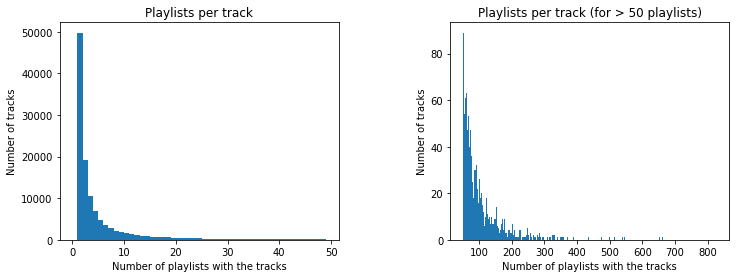

In [13]:
def plot_playlists_per_track(df):
  plt.figure(figsize=(12, 4))
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  
  plt.subplot(1, 2, 1)
  track_ps_df.hist(bins=range(0, 50))
  plt.ylabel("Number of tracks")
  plt.xlabel("Number of playlists with the tracks")
  plt.title("Playlists per track")
  plt.grid(False)

  plt.subplot(1, 2, 2)
  track_ps_df.hist(bins=range(50, track_ps_df.max()))
  plt.ylabel("Number of tracks")
  plt.xlabel("Number of playlists with the tracks")
  plt.title("Playlists per track (for > 50 playlists)")
  plt.grid(False)

  plt.subplots_adjust(wspace=0.4)

plot_playlists_per_track(df);

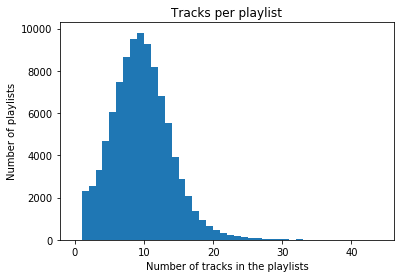

In [14]:
def plot_tracks_per_playlist(df):
  p_tracks_df = df[["pid", "traid"]].drop_duplicates()["pid"].value_counts()
  p_tracks_df.hist(bins=range(0, p_tracks_df.max()))
  plt.ylabel("Number of playlists")
  plt.xlabel("Number of tracks in the playlists")
  plt.title("Tracks per playlist")
  plt.grid(False)

plot_tracks_per_playlist(df);

In [0]:
def plot_both(df):
  plt.figure(figsize=(12, 4))
  
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  plt.subplot(1, 2, 1)
  track_ps_df.hist(bins=range(0, 50))
  plt.ylabel("#tracks")
  plt.xlabel("#playlists with the tracks")
  plt.title("Playlists per track")
  plt.grid(False)

  p_tracks_df = df[["pid", "traid"]].drop_duplicates()["pid"].value_counts()
  plt.subplot(1, 2, 2)
  p_tracks_df.hist(bins=range(0, p_tracks_df.max()))
  plt.ylabel("#playlists")
  plt.xlabel("#tracks in the playlists")
  plt.title("Tracks per playlist")
  plt.grid(False)

  plt.subplots_adjust(wspace=0.2)
  plt.suptitle("AOTM-2011");

As further preprocessing we remove the following:

*   Tracks ocurring in only one playlist: of small use
*   Playlists with less than 3 tracks: not useable for train-validation-test split



In [16]:
def with_min_track_ps(df, min_track_ps = 2):
  track_ps_df = df[["pid", "traid"]].drop_duplicates()["traid"].value_counts()
  rm_tracks_idx = track_ps_df[track_ps_df < min_track_ps].index
  df = df[~df["traid"].isin(rm_tracks_idx)]
  num_rm_tracks = rm_tracks_idx.size
  print("removed {:,} tracks which were in less than {} playlists"
        .format(num_rm_tracks, min_track_ps))
  return df

def with_min_p_inters(df, min_p_inters = 3):
  p_inters_df = df["pid"].value_counts()
  rm_p_idx = p_inters_df[p_inters_df < min_p_inters].index
  df = df[~df["pid"].isin(rm_p_idx)]
  num_rm_ps = rm_p_idx.size
  print("removed {:,} playlists which had less than {} track interactions\n"
        .format(num_rm_ps, min_p_inters))
  return df

df = with_min_track_ps(df)
df = with_min_p_inters(df)

print_statistics(df)

removed 49,786 tracks which were in less than 2 playlists
removed 6,161 playlists which had less than 3 track interactions

836,162 interactions
90,646 playlists
14,855 users
69,993 tracks
31,874 albums
11,283 artists


We also check if playlists sometimes contain the same track multiple times - and see that this is the case, but only a few times.

In [17]:
duplicates_df = df.groupby(["pid", "traid"]).size()
duplicates_df = duplicates_df[duplicates_df > 2].reset_index()

print("{} tracks duplications in playlists\n".format(len(duplicates_df)))

duplicates_df.head()

94 tracks duplications in playlists



,pid,traid,0
0,1198,SOAOVWM12A8C13996E,5
1,4030,SOIVPRW12A6310F237,4
2,4296,SOZCZTN12AF729E7EC,4
3,5105,SOPVXLX12A8C1402D5,3
4,5951,SORNOKL12D02199D15,5


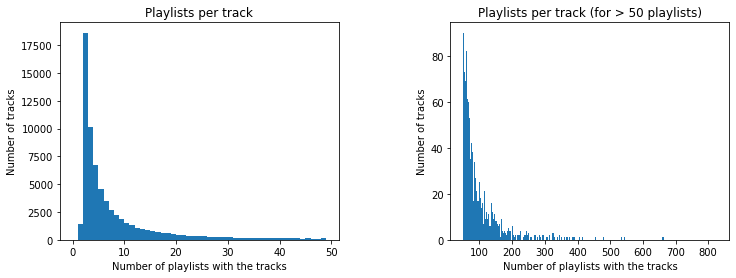

In [18]:
plot_playlists_per_track(df);

In [19]:
df[["pid", "traid"]].drop_duplicates()["traid"].value_counts().mean()

11.925221093537925

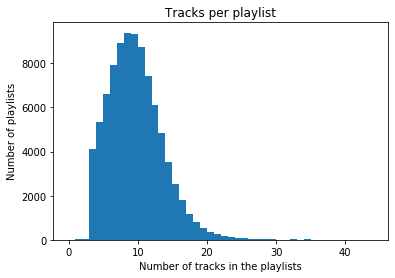

In [20]:
plot_tracks_per_playlist(df);

In [21]:
df[["pid", "traid"]].drop_duplicates()["pid"].value_counts().mean()

9.208150387220616

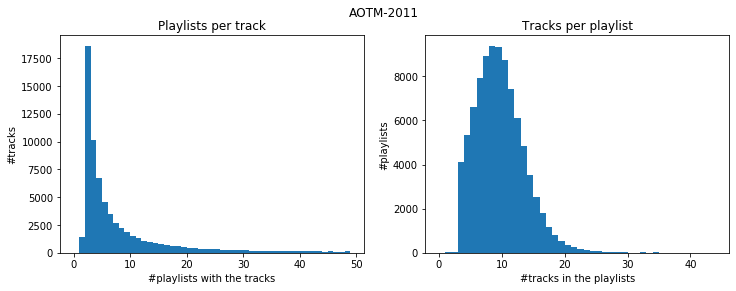

In [22]:
plot_both(df);

In [0]:
def plot_long_tail(df):
  track_counts = df["traid"].value_counts().sort_values(ascending=False)
  track_perc = track_counts.cumsum() / track_counts.sum()
  xlabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
  xticks = [x * track_counts.size for x in xlabels]
  track_perc.plot(use_index=False, ylim=(0.0, 1.0))
  plt.xticks(ticks=xticks, labels=xlabels)
  plt.ylabel("cumulative % of track occurence")
  plt.xlabel("% of tracks")
  plt.title("AOTM-2011")
  plt.grid(True);

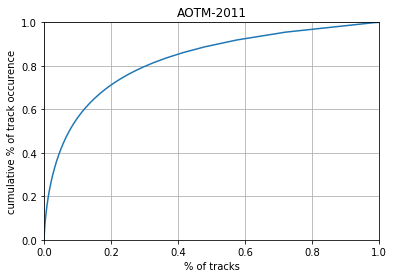

In [24]:
plot_long_tail(df)

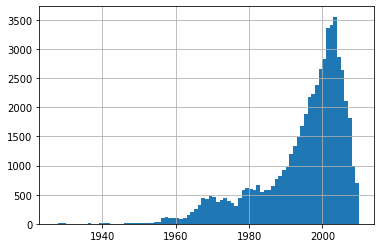

In [25]:
df[["year", "traid"]].drop_duplicates()["year"].hist(bins=int(df["year"].max() - df["year"].min()));

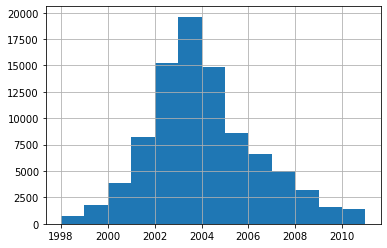

In [26]:
df[["pyear", "pid"]].drop_duplicates()["pyear"].hist(bins=int(df["pyear"].max() - df["pyear"].min()));

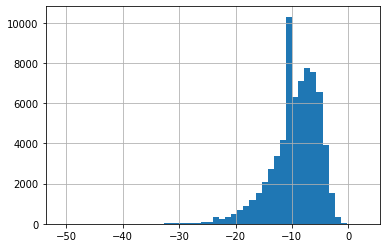

In [28]:
df.drop_duplicates("traid")["loudness"].hist(bins=50);

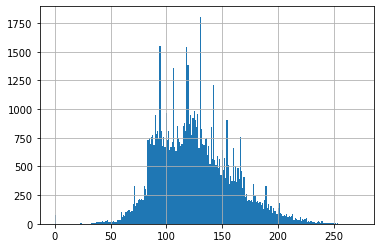

In [29]:
df.drop_duplicates("traid")["tempo"].hist(bins=250);

In [0]:
df["b_tempo"] = pd.cut(df["tempo"],
                       [0, 60, 70, 80, 90, 100, 110, 120, 130, 140,
                        150, 160, 170, 180, 190, 200, 300],
                       right=False,
                       labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                               10, 11, 12, 13, 14, 15])
df["b_tempo"] = df["b_tempo"].astype(int, copy=False)

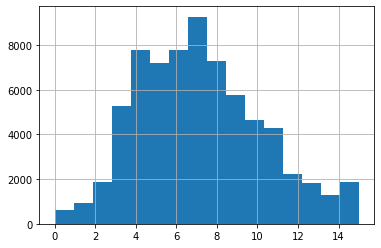

In [31]:
df.drop_duplicates("traid")["b_tempo"].hist(bins=16);

In [0]:
df["bak_tempo"] = df["tempo"]
df["tempo"] = df["b_tempo"]

Finally, we also add the previous track, album, artist and year as column.

Notable for these previous columns is that they are often not the immediately previous column since there are frequent gaps because of removed tracks (without MSD id or in less than 2 playlists). This might affect the quality of previous column relations but is a problem with the dataset.

In [33]:
def with_prev_columns(df):
  gp = df.groupby("pid")
  df["prev_traid"] = gp["traid"].shift(1)
  df["prev_albid"] = gp["albid"].shift(1)
  df["prev_artid"] = gp["artid"].shift(1)
  df["prev_year"] = gp["year"].shift(1)
  df["prev_year"].fillna(0, inplace=True)
  df["prev_year"] = df["prev_year"].astype(int, copy=False)
  df["prev_loudness"] = gp["loudness"].shift(1)
  df["prev_tempo"] = gp["tempo"].shift(1)
  df["prev_mode"] = gp["mode"].shift(1)
  df["prev_key"] = gp["key"].shift(1)
  return df

df = with_prev_columns(df)
df.head()

,category,pid,timestamp,userid,sid,traid,pyear,artid,albid,artname,traname,albname,year,key,loudness,mode,tempo,b_tempo,bak_tempo,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
34256,Rock/Pop,1,1998-01-22,Eli Lester,0,SOHVGOY12AF729EC76,1998,ARBAN8S1187FB4D22F,ARBAN8S1187FB4D22F Ben Folds Five,Ben Folds Five,Philosophy,Ben Folds Five,1995.0,0,-7,1,14,14,195,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
130601,Rock/Pop,1,1998-01-22,Eli Lester,1,SORTBLM12A8C140261,1998,AR35E9F1187B9B4877,AR35E9F1187B9B4877 The Missing Years,John Prine,All the Best,The Missing Years,1991.0,0,-14,1,3,3,89,SOHVGOY12AF729EC76,ARBAN8S1187FB4D22F Ben Folds Five,ARBAN8S1187FB4D22F,1995,-7.0,14.0,1.0,0.0
590015,Rock/Pop,1,1998-01-22,Eli Lester,1,SOWENZL12AB0186BEE,1998,ARVHCWL1187B9B8F60,ARVHCWL1187B9B8F60 B-Sides And Otherwise,Morphine,All Wrong (Album Version),B-Sides And Otherwise,1997.0,0,-10,1,5,5,108,SORTBLM12A8C140261,AR35E9F1187B9B4877 The Missing Years,AR35E9F1187B9B4877,1991,-14.0,3.0,1.0,0.0
221992,Rock/Pop,1,1998-01-22,Eli Lester,2,SOURMTG12A8C13B478,1998,ARPIRQD1187B9AE9CA,ARPIRQD1187B9AE9CA March,Michael Penn,No Myth,March,1989.0,0,-10,1,5,5,104,SOWENZL12AB0186BEE,ARVHCWL1187B9B8F60 B-Sides And Otherwise,ARVHCWL1187B9B8F60,1997,-10.0,5.0,1.0,0.0
681406,Rock/Pop,1,1998-01-22,Eli Lester,2,SOCAXNF12A81356D4D,1998,ARVFF0Y1187B9AC3CA,ARVFF0Y1187B9AC3CA Crooked Rain Crooked Rain (...,Pavement,Camera,Crooked Rain Crooked Rain (Deluxe Edition),1994.0,7,-10,1,3,3,85,SOURMTG12A8C13B478,ARPIRQD1187B9AE9CA March,ARPIRQD1187B9AE9CA,1989,-10.0,5.0,1.0,0.0


# Evaluation split

First, we define functions for converting dataframe columns to one-hot indices in accordance with a train-test-validation split.

In [0]:
def col2id_col(df, col, mappings, rvs_mappings):
  if col in mappings:
    df[col] = df[col].map(mappings[col])
    df[col].fillna(0, inplace=True)
  else:
    df[col], rvs_mappings[col] = df[col].factorize()
    df[col] += 1
    rvs_mappings[col] = rvs_mappings[col].insert(0, None)
    mappings[col] = {col_val: i for i, col_val in enumerate(rvs_mappings[col])}

  df[col] = df[col].astype("int64", copy=False)


def df2id_df(df, id_cols, mappings, rvs_mappings):
  for id_col in id_cols:
    col2id_col(df, id_col, mappings, rvs_mappings)


def split_dfs2id_dfs(train_df, test_df=None, val_df=None, copy=True, cols=[],
                     same_col_pairs=[]):
  """
  Map columns of dataframes to one-hot indices.
  Test and validation dataframes will use the mappings of the train dataframe.
  Index 0 is used for missing and unknown (test and validation) column values.

  same_col_pairs are (src_col, same_col) pairs where same_col uses the same
  mappings as src_col.
  """
  id_mappings = dict()
  rvs_id_mappings = dict()
  
  if copy:
    train_df = train_df.copy()
    if test_df is not None:
      test_df = test_df.copy()
    if val_df is not None:
      val_df = val_df.copy()
  
  dfs = [df for df in [train_df, val_df, test_df] if df is not None]

  for df in dfs:
    df2id_df(df, cols, id_mappings, rvs_id_mappings)

  for src_col, same_col in same_col_pairs:
    id_mappings[same_col] = id_mappings[src_col]
  
  same_cols = [same_col for _, same_col in same_col_pairs]

  for df in dfs:
    df2id_df(df, same_cols, id_mappings, rvs_id_mappings)

  if copy:
    return tuple(dfs)

Now we set the columns we want to map to one-hot indices.

In [0]:
# columns to use
use_cols = ["pid", "userid", "category", "pyear", "year", "artid", "albid", "traid",
            "loudness", "tempo", "mode", "key"]

# other columns to use with the same mappings as the previous columns
use_col_pairs = [("year", "prev_year"),
                 ("artid", "prev_artid"),
                 ("albid", "prev_albid"),
                 ("traid", "prev_traid"),
                 ("loudness", "prev_loudness"),
                 ("tempo", "prev_tempo"),
                 ("mode", "prev_mode"),
                 ("key", "prev_key")]

# which columns are user/context columns - and known as query context
non_track_cols = ["category", "pyear", "pid", "userid",
                  "prev_traid", "prev_albid", "prev_artid", "prev_year",
                  "prev_loudness", "prev_tempo", "prev_mode", "prev_key"]

# which columns are item columns - and known only as query seeds
track_cols = ["traid", "albid", "artid", "year", "loudness", "tempo", "mode", "key"]

Now we define the different evaluation splits to use. See the section 5.1 about evaluation design in my master's thesis.


In [0]:
def _to_query_ctx(df):
  return df[non_track_cols]


def _to_query(concat_df):
  concat_df[track_cols] = concat_df[track_cols].fillna(0)
  concat_df[track_cols] = concat_df[track_cols].astype("int64", copy=False)
  return concat_df


def get_query_seeds(query_df):
  """
  Get the seed tracks of a query dataframe
  """
  return query_df[query_df["traid"] != 0]


def get_query_ctx(query_df):
  """
  Get the context of a query dataframe - 
  the actual target information without any target track information
  """
  return _to_query_ctx(query_df[query_df["traid"] == 0])


def _last_track_split(df, as_val):
  i = 2 if as_val else 1
  gp = df.groupby("pid")
  train_df = df[gp.cumcount(ascending=False) >= i]
  test_df = gp.nth(-i).reset_index()
  return train_df, test_df


def _users_split(df, n_test_users, seed):
  users = df["pid"].drop_duplicates()
  np.random.seed(seed)
  test_users = np.random.choice(users, n_test_users, replace=False)
  test_users_mask = df["pid"].isin(test_users)
  test_users_df = df[test_users_mask]
  train_users_df = df[~test_users_mask]
  return train_users_df, test_users_df


def _known_last_track_split(df, as_val, seed, n_test_users=None):
  train_df, test_df = _last_track_split(df, as_val)

  train_tracks = pd.Index(train_df["traid"].drop_duplicates())
  test_tracks = pd.Index(test_df["traid"].drop_duplicates())
  unknown_tracks = test_tracks.difference(train_tracks)
  unknown_mask = test_df["traid"].isin(unknown_tracks)
  unknown_pids = pd.Index(test_df[unknown_mask]["pid"])

  unknown_mask = df["pid"].isin(unknown_pids)
  known_df = df[~unknown_mask]
  unknown_df = df[unknown_mask]

  if n_test_users:
    train_users_df, test_users_df = _users_split(known_df, n_test_users, seed)
    train_df, test_df = _last_track_split(test_users_df, as_val)
    train_df = pd.concat([unknown_df, train_users_df, train_df], sort=False)
  else:
    train_df, test_df = _last_track_split(known_df, as_val)
    train_df = pd.concat([unknown_df, train_df], sort=False)

  train_df.sort_values("pid", inplace=True, kind="mergesort")

  return train_df, test_df


def _last_track_query(train_df, test_df, n_test_users=None):
  if n_test_users:
    test_pids = pd.Index(test_df["pid"])
    test_query_df = train_df[train_df["pid"].isin(test_pids)]
  else:
    test_query_df = train_df

  test_query_ctx_df = _to_query_ctx(test_df)
  test_query_df = pd.concat([test_query_df, test_query_ctx_df], sort=False)
  test_query_df = _to_query(test_query_df)

  return test_query_df


def last_track_split(df, as_val=False, n_test_users=None, seed=1):
  """
  Split the dataframe into train and validation or test dataframes.
  The test dataframe contains the last track of each or n_test_users random
  users, the validation dataframe the second-last. Only returns validation or 
  test users with known (second-)last track indices.

  Also returns a query dataframe corresponding to the validation or test
  dataframe.

  Columns are mapped to one-hot indices in the process. 
  """
  train_df, test_df = _known_last_track_split(df, as_val, seed, n_test_users)

  train_df, test_df = split_dfs2id_dfs(train_df, test_df=test_df, cols=use_cols,
                                       same_col_pairs=use_col_pairs)

  return train_df, test_df, _last_track_query(train_df, test_df, n_test_users)


def _seed_users_split(df, n_test_users, include_val, n_seed_tracks, seed):
  gp = df.groupby("pid")
  seed_df = gp.filter(lambda g: g.size > n_seed_tracks)
  non_seed_df = gp.filter(lambda g: g.size <= n_seed_tracks)

  train_df, test_df = _users_split(seed_df, n_test_users, seed)

  val_df = None
  if include_val:
    train_df, val_df = _users_split(train_df, n_test_users, seed)

  train_df = pd.concat([train_df, non_seed_df], sort=False)
  train_df.sort_values("pid", inplace=True, kind="mergesort")

  if include_val:
    return train_df, val_df, test_df
  else:
    return train_df, test_df


def _seed_query_split(df, n_seed_tracks):
  gp = df.groupby("pid", as_index=False)
  test_df = df[gp.cumcount() >= n_seed_tracks]
  query_df = gp.head(n_seed_tracks)
  query_ctx_df = _to_query_ctx(gp.nth(n_seed_tracks))
  query_df = _to_query(pd.concat([query_df, query_ctx_df], sort=False))
  query_df.sort_values("pid", inplace=True, kind="mergesort")
  return test_df, query_df


def users_split(df, n_test_users, include_val=False, n_seed_tracks=5, seed=1):
  """
  Split the dataframe into train, optional validation and test dataframes.
  The test and validation dataframe each contain n_test_users users and
  the train dataframe the other users. The validation and test dataframes
  each contain the users tracks after his/her first n_seed_tracks tracks.
  Only returns validation or test users with more than n_seed_tracks tracks.

  Also returns query dataframes corresponding to the validation and test
  dataframes.

  Columns are mapped to one-hot indices in the process,
  but train, validation and test dataframes have separate pid indices,
  all start from 0!
  """
  dfs = _seed_users_split(df, n_test_users, include_val, n_seed_tracks, seed)

  # pids are separate for each split - all start from 0, to different n
  dfs = (split_dfs2id_dfs(df, cols=["pid"])[0] for df in dfs)
  if include_val:
    train_df, val_df, test_df = dfs
  else:
    train_df, test_df = dfs
    val_df = None

  use_cols_no_pid = use_cols[1:]
  split_dfs2id_dfs(train_df, test_df=test_df, val_df=val_df,
                   cols=use_cols_no_pid, same_col_pairs=use_col_pairs,
                   copy=False)
  
  test_df, test_query_df = _seed_query_split(test_df, n_seed_tracks)
  val_query_df = None
  if include_val:
    val_df, val_query_df = _seed_query_split(val_df, n_seed_tracks)

  dfs = train_df, val_df, test_df, val_query_df, test_query_df
  return tuple(df for df in dfs if df is not None)

We won't use the name columns for the models but will use them for analysis of the recommendations for the first and second example playlist.

In [0]:
def to_names_index(df):
  df = df[["traid", "traname", "albname", "artname"]].drop_duplicates()
  return df.set_index("traid")


def with_names(df, names_index_df):
  return df.join(names_index_df, on="traid").drop(columns=["traid"])


def drop_names(dfs):
  for df in dfs:
    df.drop(columns=["traname", "albname", "artname"], inplace=True)

We now create a last track split and view the structure of the results.

In [38]:
train_df, test_df, test_query_df = last_track_split(df, n_test_users=1000)
names_df = to_names_index(train_df)
drop_names([train_df, test_df, test_query_df])

train_df.head()

,category,pid,timestamp,userid,sid,traid,pyear,artid,albid,year,key,loudness,mode,tempo,b_tempo,bak_tempo,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
34256,1,1,1998-01-22,1,0,1,1,1,1,1,1,1,1,1,14,195,0,0,0,0,0,0,0,0
130601,1,1,1998-01-22,1,1,2,1,2,2,2,1,2,1,2,3,89,1,1,1,1,1,1,1,1
590015,1,1,1998-01-22,1,1,3,1,3,3,3,1,3,1,3,5,108,2,2,2,2,2,2,1,1
221992,1,1,1998-01-22,1,2,4,1,4,4,4,1,3,1,3,5,104,3,3,3,3,3,3,1,1
681406,1,1,1998-01-22,1,2,5,1,5,5,5,2,3,1,2,3,85,4,4,4,4,3,3,1,1


In [39]:
test_df.head()

,pid,category,timestamp,userid,sid,traid,pyear,artid,albid,year,key,loudness,mode,tempo,b_tempo,bak_tempo,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
0,161,1,1998-02-08 00:00:00,122,3,239,1,86,223,1,11,8,1,3,5,100,119,113,98,1,4,8,1,1
1,190,2,1998-02-05 00:00:00,140,3,2890,1,1231,2254,14,5,3,2,6,4,90,1468,1259,76,14,4,6,1,12
2,202,2,1999-01-08 13:15:00,142,7,1867,2,711,1556,33,9,2,2,8,12,179,166,159,125,11,13,7,2,9
3,458,4,1998-07-22 00:00:00,265,3,15917,1,261,341,3,12,14,1,6,4,99,1414,975,248,11,14,5,2,1
4,671,2,1998-11-09 00:00:00,342,6,5578,1,729,1175,11,2,13,2,6,4,94,3983,2273,1241,0,7,2,2,1


In [40]:
get_query_seeds(test_query_df).head()

,category,pid,timestamp,userid,sid,traid,pyear,artid,albid,year,key,loudness,mode,tempo,b_tempo,bak_tempo,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
8406,1,161,1998-02-08,122,0,1253,1,194,1091,2,4,7,2,14,9.0,145.0,0,0,0,0,0,0,0,0
467820,1,161,1998-02-08,122,0,310,1,184,288,11,4,12,1,6,4.0,93.0,1253,1091,194,2,7,14,2,4
927234,1,161,1998-02-08,122,0,428,1,222,272,0,4,4,2,6,4.0,99.0,310,288,184,11,12,6,1,4
1386648,1,161,1998-02-08,122,0,1254,1,184,226,5,11,7,1,13,13.0,187.0,428,272,222,0,4,6,2,4
1846062,1,161,1998-02-08,122,0,1255,1,96,1092,17,9,12,1,11,6.0,119.0,1254,226,184,5,7,13,1,11


In [41]:
get_query_ctx(test_query_df).head()

,category,pyear,pid,userid,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
0,1,1,161,122,119,113,98,1,4,8,1,1
1,2,1,190,140,1468,1259,76,14,4,6,1,12
2,2,2,202,142,166,159,125,11,13,7,2,9
3,4,1,458,265,1414,975,248,11,14,5,2,1
4,2,1,671,342,3983,2273,1241,0,7,2,2,1


We also view the track, album and artist names of the first playlist.

Later we can then also compare how well predicted tracks intuitively fit to the playlist.

In [42]:
with_names(get_query_seeds(test_query_df).head(20)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
8406,161,Black,Seattle Washington November 5 2000,Pearl Jam
467820,161,Crash Into Me,Listener Supported,DAVE MATTHEWS BAND
927234,161,You Were Meant For Me,The Essential Live Songbook,Jewel
1386648,161,Lover Lay Down,Live At Red Rocks 8.15.95,DAVE MATTHEWS BAND
1846062,161,Every Breath You Take,Certifiable,The Police
2305476,161,I'll Back You Up,Remember Two Things,DAVE MATTHEWS BAND
2764890,161,I Shall Believe,Tuesday Night Music Club,Sheryl Crow
3224304,161,Immortality,rearviewmirror (greatest hits 1991-2003),Pearl Jam
3683718,161,Imagine,Lennon Legend,John Lennon
105670,161,Moondance,Still On Top - The Greatest Hits,Van Morrison


In [43]:
with_names(test_df.head(1)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
0,161,Fake Plastic Trees,Sunny Afternoon,Radiohead


# Evaluation metrics

As evaluation metrics we will use NDCG and hit rates / recall@n.

In [0]:
def with_time(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if result is None:
          return (te - ts)
        else:
          return result, (te - ts)
          
    return timed


def hit_rate(pred_tracks_df, true_tracks_df, n=1):
  """
  Computes the mean user hit rate.
  
  Assumes
   * pred_tracks_df sorted by score per pid
   * true_tracks_df has only one true track per pid!
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(n)
  hits = len(pred_tracks_df.join(true_tracks_df.set_index(["pid", "traid"]),
                                 on=["pid", "traid"], how="inner"))
  hit_rate = hits / pred_tracks_df["pid"].nunique()
  
  return hit_rate


def hit_rates(pred_tracks_df, true_tracks_df, max_n=500):
  """
  Computes the mean user hit rate for each n up to max_n.
  
  Assumes
   * pred_tracks_df sorted by score per pid
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(max_n)
  
  hits = pred_tracks_df
  hits["n"] = hits.groupby("pid").cumcount()
  true_tracks_df["r"] = true_tracks_df.groupby("pid")["traid"].transform("size")
  hits = hits.join(true_tracks_df.set_index(["pid", "traid"]),
                   on=["pid", "traid"], how="inner")
  hits["hits"] = 1.0 / hits["r"]
  
  cum_hits = hits.groupby("n")["hits"].sum().cumsum()
  cum_hits = cum_hits.reindex(range(0, max_n), method="pad")
  cum_hits.fillna(0.0, inplace=True)
  
  cum_hit_rates = cum_hits.to_numpy() / pred_tracks_df["pid"].nunique()
  
  return cum_hit_rates


def ndcg(pred_tracks_df, true_tracks_df, n=500):
  """
  Computes the mean user NDCG.
  
  Assumes pred_tracks_df sorted by score per pid
  """
  
  pred_tracks_df = pred_tracks_df.groupby("pid").head(n)
  true_tracks_df = true_tracks_df.groupby("pid").head(n)
  
  dcgs = pred_tracks_df
  dcgs["n"] = dcgs.groupby("pid").cumcount()
  dcgs = dcgs.join(true_tracks_df.set_index(["pid", "traid"]),
                   on=["pid", "traid"], how="inner")
  dcgs["dcg"] = 1.0 / np.log2(dcgs["n"].to_numpy() + 2)
  dcg = dcgs.groupby("pid")["dcg"].sum()
  
  idcgs = true_tracks_df
  idcgs["n"] = idcgs.groupby("pid").cumcount()
  idcgs["dcg"] = 1.0 / np.log2(idcgs["n"].to_numpy() + 2)
  idcg = idcgs.groupby("pid")["dcg"].sum()
  
  return (dcg / idcg).sum()  / pred_tracks_df["pid"].nunique()

# Baseline algorithms

Now we want to evaluate some baseline algorithms on the dataset. We will use the following algorithms.

*   PopRank
*   Same Artist - Greatest Hits (SAGH)
*   kNN user-based collaborative filtering

These algorithms were presented and evaluated for playlist generation in


> Geoffray Bonnin and Dietmar Jannach.<br>
> **Automated generation of music playlists:Survey and experiments**.<br>
> *In ACM CSUR, pages 26:1--26:35, 2015*

## Implementation

In [0]:
def df2csr(df, cols, nodup=True, shape=None, return_df=False):
  """
  Converts a dataframe with 2 or 3 columns into a csr matrix where
   * column 1 are the row indices
   * column 2 are the column indices
   * column 3 are the values or all values are one

  This csr matrix can be more efficient to work with in some algorithms
  """
  
  rowcol = cols[0]
  colcol = cols[1]
  valcol = cols[2] if len(cols) > 2 else None
    
  if nodup:
    dfcols = [col for col in cols if col]
    df = df[dfcols].drop_duplicates()
  
  row_arr = df[rowcol].to_numpy()
  col_arr = df[colcol].to_numpy()
  val_arr = df[valcol].to_numpy() if valcol else np.ones(row_arr.shape)
  
  mat = csr_matrix((val_arr, (row_arr, col_arr)), shape=shape)
  
  if not nodup:
    mat.sum_duplicates()
  
  if return_df:
    return mat, df
  
  return mat


class TrackArtistEnricher:
  
  def fit(self, train_df):
    self.tra_art_s = (train_df[["traid", "artid"]]
                      .drop_duplicates()
                      .append(pd.DataFrame({"traid": [0], "artid": [0]}))
                      .set_index("traid"))
  
  def transform(self, df):
    return df.join(self.tra_art_s, on="traid")

  
t_cols = ["score", "pid", "traid"]

In [0]:
class PopRank:
  
  @with_time
  def fit(self, train_df, count_listens=False, tf=False):
    nodup = not count_listens and not tf
    tra_user_mat = df2csr(train_df, ["traid", "pid"], nodup=nodup)
    
    if tf:
      tra_user_mat.data = np.log2(1 + tra_user_mat.data)

    scores = tra_user_mat.sum(axis=1).A.reshape(-1)
    
    self.scores_s = pd.Series(data=scores, name="score")
    self.scores_s.index.name = "traid"
  
  def transform_no_filter(self, query_df, n):
    users_df = query_df[["pid"]].drop_duplicates()
    users_df["tmpkey"] = 0
    t_df = self.scores_s.nlargest(n).reset_index().copy()
    t_df["tmpkey"] = 0
    return users_df.merge(t_df, on="tmpkey")
  
  def transform_filter(self, query_df, n):    
    gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
    m = gp.size().max()
    
    # trick for efficiently filtering user tracks
    # use mutable scores series
    # 
    #  1. get best n + m (maximum user tracks) sorted scores
    nmlargest_idx = self.scores_s.nlargest(n + m).index.to_numpy()

    t_dfs = []
    for userid, user_df in gp:
      user_tracks = user_df["traid"].to_numpy()
      
      #  2. set scores of filtered tracks to 0 - changes df state
      tmpscores = self.scores_s.iloc[user_tracks]
      self.scores_s.iloc[user_tracks] = 0.0

      sorted_scores = self.scores_s.iloc[nmlargest_idx].to_numpy()

      #  3. get best n sorted scores without added 0s
      nonzero_idx = np.nonzero(sorted_scores)[0][:n]
      resorted_idx = nmlargest_idx[nonzero_idx]

      #  4. reset 0 scores - changes df state back
      t_s = self.scores_s.iloc[resorted_idx]

      self.scores_s.iloc[user_tracks] = tmpscores

      t_df = t_s.reset_index()
      t_df["pid"] = userid
      t_dfs.append(t_df)
    
    return pd.concat(t_dfs, sort=False)
  
  @with_time
  def transform(self, query_df, n=500, filter_user_tracks=False):
    if filter_user_tracks:
      t_df = self.transform_filter(query_df, n)
    else:
      t_df = self.transform_no_filter(query_df, n)
    
    return t_df[t_cols]

In [0]:
class SAGH:
  
  @with_time
  def fit(self, train_df, count_listens=False, tf=False):
    self.pop_rank = PopRank()
    self.pop_rank.fit(train_df, count_listens=count_listens, tf=tf)
    
    art_en = TrackArtistEnricher()
    art_en.fit(train_df)
    art_tra_scores_df = art_en.transform(self.pop_rank.scores_s.reset_index())
    art_tra_scores_df.drop(0, inplace=True)  # remove missing artists
    
    self.art_tra_mat = df2csr(art_tra_scores_df,
                              ["artid", "traid", "score"],
                              nodup=True)
  
  @with_time
  def transform(self, query_df, n=500, filter_user_tracks=False):
    userids = query_df["pid"].drop_duplicates()  
    user_art_mat = df2csr(query_df, ["pid", "artid"],
                          nodup=True,
                          shape=(userids.max() + 1, self.art_tra_mat.shape[0]))

    # popularity scores of tracks of same artists
    tra_scores_mat = user_art_mat * self.art_tra_mat

    if filter_user_tracks:
      # trick for efficiently filtering user tracks
      # use same mutable mask for each user 
      gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
      tracks_mask = np.ones(self.art_tra_mat.shape[1])
    else:
      gp = ((userid, None) for userid in userids)

    t_dfs = []      
    for userid, user_df in gp:
      start = time.time()

      l = tra_scores_mat.indptr[userid]
      r = tra_scores_mat.indptr[userid + 1]

      userids = np.full(r - l, userid)
      tracks = tra_scores_mat.indices[l:r]
      scores = tra_scores_mat.data[l:r]

      t_df = pd.DataFrame({"pid": userids, "traid": tracks, "score": scores})

      if filter_user_tracks:
        user_tracks = user_df["traid"].to_numpy()
        tracks_mask[user_tracks] = 0
        
        t_df = t_df.nlargest(n + len(user_tracks), "score")
        n_offsets = np.nonzero(tracks_mask[t_df["traid"].to_numpy()])[0][:n]
        t_df = t_df.iloc[n_offsets]
        
        tracks_mask[user_tracks] = 1
      else:
        t_df = t_df.nlargest(n, "score")
      
      t_dfs.append(t_df)

    return pd.concat(t_dfs, sort=False)[t_cols]

In [0]:
class KNN:
  
  @with_time
  def fit(self, train_df, count_listens=False, tfidf=False):    
    self.user_tra_mat = df2csr(train_df, ["pid", "traid"], nodup=not tfidf)
    
    self.tfidf_trans = None
    if tfidf:
      self.tfidf_trans = TfidfTransformer(sublinear_tf=True)
    if count_listens:
      self.tfidf_trans = TfidfTransformer(norm=None, use_idf=False)
    if tfidf or count_listens:
      self.user_tra_mat = self.tfidf_trans.fit_transform(self.user_tra_mat)
    
    # for cosine similarity
    self.tra_user_normalized = normalize(self.user_tra_mat).T
  
  @with_time
  def transform(self, query_df, n=500, k=50, filter_user_tracks=False):    
    mat = df2csr(query_df, ["pid", "traid"],
                 nodup=not self.tfidf_trans,
                 shape=self.user_tra_mat.shape)
    
    if self.tfidf_trans:
      mat = self.tfidf_trans.transform(mat)

    normalize(mat, copy=False)  # for cosine similarity
    
    # cosine similarity
    # this needs O(n^2) memory for n users, but is stored sparse at least
    nn_scores = mat * self.tra_user_normalized
    
    if filter_user_tracks:
      # trick for efficiently filtering user tracks
      # use same mutable mask for each user 
      gp = query_df[["pid", "traid"]].drop_duplicates().groupby("pid")
      tracks_mask = np.ones(self.user_tra_mat.shape[1])
    else:
      gp = ((i, i) for i in range(self.user_tra_mat.shape[0]))

    t_dfs = []
    for userid, user_df in gp:
      # k nearest neighbors by cosine similarity
      l = nn_scores.indptr[userid]
      r = nn_scores.indptr[userid + 1]
      if (r - l) <= k:
        nn_users = nn_scores.indices[l:r]
      else:
        k_offsets = np.argpartition(nn_scores.data[l:r], -k)[-k:]
        nn_users = nn_scores.indices[l + k_offsets]

      # track scores as tracks of neighbors weighted by cosine similarity
      scores =  nn_scores[userid,nn_users] * self.user_tra_mat[nn_users,:]

      userids = np.full(len(scores.indices), userid)
      tracks = scores.indices
      scores = scores.data
      
      t_df = pd.DataFrame({"pid": userids, "traid": tracks, "score": scores})
      
      if filter_user_tracks:
        user_tracks = user_df["traid"].to_numpy()
        tracks_mask[user_tracks] = 0
        
        t_df = t_df.nlargest(n + user_tracks.size, "score")
        n_offsets = np.nonzero(tracks_mask[t_df["traid"].to_numpy()])[0][:n]
        t_df = t_df.iloc[n_offsets]
        
        tracks_mask[user_tracks] = 1
      else:
        t_df = t_df.nlargest(n, "score")
        
      t_dfs.append(t_df)
    
    return pd.concat(t_dfs, sort=False)[t_cols]

## Evaluation

In our evaluation we filter out tracks that are already in the playlist (*filter_user_tracks*), as only a few tracks are contained in a playlist multiple times. We therefore also don't use the *count_listens* or *tf* parameters.

In [0]:
pop_rank = PopRank()
pop_rank_fit_time = pop_rank.fit(train_df)
pop_rank_df, pop_rank_trans_time = pop_rank.transform(
    get_query_seeds(test_query_df), filter_user_tracks=True)
pop_rank_hit_rates = hit_rates(pop_rank_df, test_df)
pop_rank_ndcg = ndcg(pop_rank_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(pop_rank_hit_rates[0], pop_rank_ndcg, pop_rank_fit_time,
              pop_rank_trans_time))

with_names(pop_rank_df.head(), names_df)

0.005000 hit rate
0.028205 ndcg

0.18609s fit time 
4.02432s trans time


,score,pid,traname,albname,artname
0,822.0,161,Where Is My Mind?,Wave Of Mutilation: Best Of Pixies,Pixies
1,663.0,161,In The Aeroplane Over The Sea,In The Aeroplane Over The Sea,Neutral Milk Hotel
2,660.0,161,Love Will Tear Us Apart,Let The Movie Begin,Joy Division
3,657.0,161,Pink Moon,Pink Moon,Nick Drake
4,650.0,161,Such Great Heights,Grey's Anatomy Original Soundtrack,The Postal Service


In [0]:
del pop_rank

In [0]:
sagh = SAGH()
sagh_fit_time = sagh.fit(train_df)
sagh_df, sagh_trans_time = sagh.transform(get_query_seeds(test_query_df),
                                          filter_user_tracks=True)
sagh_hit_rates = hit_rates(sagh_df, test_df)
sagh_ndcg = ndcg(sagh_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(sagh_hit_rates[0], sagh_ndcg, sagh_fit_time, sagh_trans_time))

with_names(sagh_df.head(), names_df)

0.012012 hit rate
0.041519 ndcg

0.28608s fit time 
4.93520s trans time


,score,pid,traname,albname,artname
608,271.0,161,Brown Eyed Girl,Letter From Vietnam Vol. 7,Van Morrison
378,171.0,161,Every Little Thing She Does Is Magic,The Very Best Of Sting And The Police,The Police
318,167.0,161,Born To Run,Greatest Hits,Bruce Springsteen
517,165.0,161,Comfortably Numb,Is There Anybody Out There? / The Wall Live P...,Pink Floyd
563,155.0,161,Instant Karma! (We All Shine On) (Live),Live In New York City,John Lennon


In [0]:
del sagh
del sagh_df

For kNN the best k is determined through evaluations on the validation set.

In [0]:
train_df, val_df, val_query_df = last_track_split(df, as_val=True,
                                                  n_test_users=1000)

In [0]:
ks = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
knn = KNN()
knn_fit_time = knn.fit(train_df)

knn_hit_rates = dict()
knn_ndcgs = dict()

for k in ks:
  knn_df, _= knn.transform(get_query_seeds(val_query_df), k=k,
                           filter_user_tracks=True)
  knn_hit_rates[k] = hit_rates(knn_df, val_df)
  knn_ndcgs[k] = ndcg(knn_df, val_df)

In [0]:
rows = [[knn_ndcgs[k] for k in ks], [knn_hit_rates[k][0] for k in ks]]
index = ["NDCG", "Hit rate"]        
pd.DataFrame.from_records(rows, columns=ks, index=index)

,10,50,100,150,200,250,300,350,400,450,500,1000
NDCG,0.049065,0.060095,0.066486,0.067219,0.067846,0.068541,0.069449,0.069029,0.068578,0.068423,0.067517,0.06663
Hit rate,0.021000,0.021000,0.022000,0.022000,0.023000,0.025000,0.024000,0.022000,0.019000,0.018000,0.016000,0.01600


The best k - *300* - is then used for the evaluation.

---



In [0]:
train_df, test_df, test_query_df = last_track_split(df, n_test_users=1000)

In [0]:
knn = KNN()
knn_fit_time = knn.fit(train_df)
knn_df, knn300_trans_time = knn.transform(get_query_seeds(test_query_df), k=300,
                                          filter_user_tracks=True)
knn300_hit_rates = hit_rates(knn_df, test_df)
knn300_ndcg = ndcg(knn_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(knn300_hit_rates[0], knn300_ndcg, knn_fit_time,
              knn300_trans_time))

with_names(knn_df.head(), names_df)

0.022022 hit rate
0.074822 ndcg

0.18867s fit time 
5.53161s trans time


,score,pid,traname,albname,artname
1162,1.428561,161,State Of Love And Trust,Seattle Washington November 5 2000,Pearl Jam
1163,1.319624,161,Daughter,Live On Two Legs,Pearl Jam
668,1.265795,161,Your Body Is A Wonderland,Your Body Is A Wonderland (Live Version),John Mayer
1214,1.109212,161,Satellite,Live At Red Rocks 8.15.95,DAVE MATTHEWS BAND
1207,1.108354,161,Two Step,DMB Live Trax Vol. 6,DAVE MATTHEWS BAND


In [0]:
del knn
del knn_df

The final evaluation results are shown below.
One can see that unsurprisingly SAGH is better than Pop Rank and kNN better than SAGH.

In [0]:
cols = ["Pop Rank", "SAGH", "kNN, k 300"]
rows = [[pop_rank_ndcg, sagh_ndcg, knn300_ndcg],
        [pop_rank_hit_rates[0], sagh_hit_rates[0],  knn300_hit_rates[0]]]
index = ["NDCG", "Hit rate"]
pd.DataFrame.from_records(rows, columns=cols, index=index)

,Pop Rank,SAGH,"kNN, k 300"
NDCG,0.028205,0.041519,0.074822
Hit rate,0.005000,0.012012,0.022022


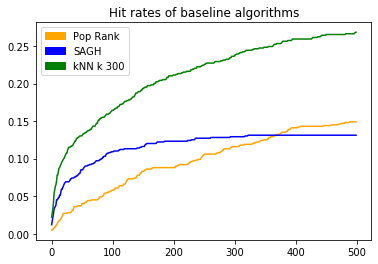

In [0]:
def plot_baseline_hit_rates(n=500):
  plt.plot(pop_rank_hit_rates[:n], color="orange")
  plt.plot(sagh_hit_rates[:n], color="blue")
  plt.plot(knn300_hit_rates[:n], color="green")

  orange_patch = mpatches.Patch(color="orange", label="Pop Rank")
  blue_patch = mpatches.Patch(color="blue", label="SAGH")
  green_patch = mpatches.Patch(color="green", label="kNN k 300")
  patches = [orange_patch, blue_patch, green_patch]
  plt.legend(handles=patches)

  plt.title("Hit rates of baseline algorithms")
  
plot_baseline_hit_rates();

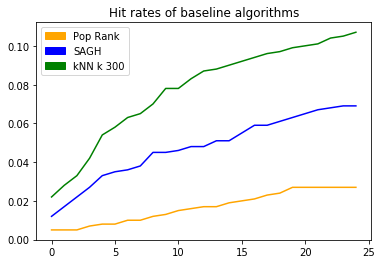

In [0]:
plot_baseline_hit_rates(n=25);

## Cold start evaluation

Besides an evaluation using a last-track split where we recommend the last track for each playlist we also perform an evaluation using a playlist split where we recommend all missing tracks for beginnings (5 seed tracks) of playlists which were entirely unknown during training.

In [0]:
train_df, test_df, test_query_df = users_split(df, 1000,
                                               include_val=False,
                                               n_seed_tracks=5)
names_df = to_names_index(train_df)
drop_names([train_df, test_df, test_query_df])

train_df.head()

,category,pid,timestamp,userid,sid,traid,pyear,artid,albid,year,prev_traid,prev_albid,prev_artid,prev_year
34256,1,1,1998-01-22,1,0,1,1,1,1,1,0,0,0,0
130601,1,1,1998-01-22,1,1,2,1,2,2,2,1,1,1,1
590015,1,1,1998-01-22,1,1,3,1,3,3,3,2,2,2,2
221992,1,1,1998-01-22,1,2,4,1,4,4,4,3,3,3,3
681406,1,1,1998-01-22,1,2,5,1,5,5,5,4,4,4,4


In [0]:
get_query_ctx(test_query_df).head(1)

,category,timestamp,pid,userid,prev_traid,prev_albid,prev_artid,prev_year
418710,2,1998-01-23,1,0,2695,882,318,9


In [0]:
with_names(get_query_seeds(test_query_df).head()[["pid", "traid"]], names_df)

,pid,traname,albname,artname
51833,1,Somebody To Shove,Grave Dancers Union,Soul Asylum
147521,1,Mr. Jones,Films About Ghosts (The Best Of Counting Crows),Counting Crows
237709,1,Selling The Drama,Best Of Live,Live
317019,1,In A Big Country,The Universal Masters Collection,Big Country
378513,1,Would?,Greatest Hits,Alice In Chains


In [0]:
with_names(test_df.head(6)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
418710,1,Sister,Foma,The Nixons
878124,1,I Feel So Good,Rumor And Sigh,Richard Thompson
1337538,1,Don't Change (Album Version),Volume 2,Goo Goo Dolls
1796952,1,Your Love,Super Hits,The Outfield
2256366,1,Bi,Stain,Living Colour
440687,1,Even Flow,Ten (Legacy Edition),Pearl Jam


In [0]:
pop_rank = PopRank()
c_pop_rank_fit_time = pop_rank.fit(train_df)
pop_rank_df, c_pop_rank_trans_time = pop_rank.transform(
    get_query_seeds(test_query_df), filter_user_tracks=True)
c_pop_rank_hit_rates = hit_rates(pop_rank_df, test_df)
c_pop_rank_ndcg = ndcg(pop_rank_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_pop_rank_hit_rates[0], c_pop_rank_ndcg, c_pop_rank_fit_time,
              c_pop_rank_trans_time))

with_names(pop_rank_df.head(), names_df)

0.000998 hit rate
0.031671 ndcg

0.18376s fit time 
3.93593s trans time


,score,pid,traname,albname,artname
0,818.0,1,Where Is My Mind?,Wave Of Mutilation: Best Of Pixies,Pixies
1,655.0,1,In The Aeroplane Over The Sea,In The Aeroplane Over The Sea,Neutral Milk Hotel
2,653.0,1,Pink Moon,Pink Moon,Nick Drake
3,648.0,1,Love Will Tear Us Apart,Let The Movie Begin,Joy Division
4,648.0,1,Such Great Heights,Grey's Anatomy Original Soundtrack,The Postal Service


In [0]:
del pop_rank

In [0]:
sagh = SAGH()
c_sagh_fit_time = sagh.fit(train_df)
sagh_df, c_sagh_trans_time = sagh.transform(get_query_seeds(test_query_df),
                                            filter_user_tracks=True)
c_sagh_hit_rates = hit_rates(sagh_df, test_df)
c_sagh_ndcg = ndcg(sagh_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_sagh_hit_rates[0], c_sagh_ndcg, c_sagh_fit_time, c_sagh_trans_time))

with_names(sagh_df.head(), names_df)

0.005138 hit rate
0.045524 ndcg

0.28393s fit time 
4.73987s trans time


,score,pid,traname,albname,artname
78,251.0,1,A Long December,Recovering The Satellites,Counting Crows
74,158.0,1,Round Here,Across A Wire - Live From New York,Counting Crows
147,91.0,1,I Alone (Live),Live At The Paradiso - Amsterdam,Live
99,91.0,1,Runaway Train,Grave Dancers Union,Soul Asylum
73,88.0,1,Rain King,Across A Wire - Live From New York,Counting Crows


In [0]:
del sagh
del sagh_df

In [0]:
knn = KNN()
c_knn300_fit_time = knn.fit(train_df)
knn_df, c_knn300_trans_time = knn.transform(get_query_seeds(test_query_df),
                                            filter_user_tracks=True, k=300)
c_knn300_hit_rates = hit_rates(knn_df, test_df)
c_knn300_ndcg = ndcg(knn_df, test_df)

print("{:.6f} hit rate\n{:.6f} ndcg\n\n{:.5f}s fit time \n{:.5f}s trans time"
      .format(c_knn300_hit_rates[0], c_knn300_ndcg, c_knn300_fit_time, c_knn300_trans_time))

with_names(knn_df.head(), names_df)

0.009806 hit rate
0.087620 ndcg

0.17171s fit time 
5.52086s trans time


,score,pid,traname,albname,artname
803,2.347904,1,Round Here,Across A Wire - Live From New York,Counting Crows
1777,2.247222,1,No Rain,Blind Melon,Blind Melon
1637,2.024947,1,A Long December,Recovering The Satellites,Counting Crows
802,1.582953,1,Rain King,Across A Wire - Live From New York,Counting Crows
1884,1.538697,1,Cannonball,Cannonball,The Breeders


In [0]:
del knn
del knn_df

In [0]:
cols = ["Pop Rank", "SAGH", "kNN, k 300"]
rows = [[c_pop_rank_ndcg, c_sagh_ndcg, c_knn300_ndcg],
        [c_pop_rank_hit_rates[0], c_sagh_hit_rates[0], c_knn300_hit_rates[0]]]
index = ["NDCG", "Hit rate"]
pd.DataFrame.from_records(rows, columns=cols, index=index)

,Pop Rank,SAGH,"kNN, k 300"
NDCG,0.031671,0.045524,0.087620
Hit rate,0.000998,0.005138,0.009806


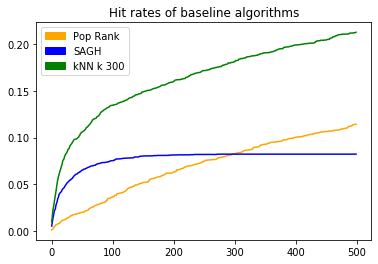

In [0]:
def plot_c_baseline_hit_rates(n=500):
  plt.plot(c_pop_rank_hit_rates[:n], color="orange")
  plt.plot(c_sagh_hit_rates[:n], color="blue")
  plt.plot(c_knn300_hit_rates[:n], color="green")

  orange_patch = mpatches.Patch(color="orange", label="Pop Rank")
  blue_patch = mpatches.Patch(color="blue", label="SAGH")
  green_patch = mpatches.Patch(color="green", label="kNN k 300")
  patches = [orange_patch, blue_patch, green_patch]
  plt.legend(handles=patches)

  plt.title("Hit rates of baseline algorithms")
  
plot_c_baseline_hit_rates();

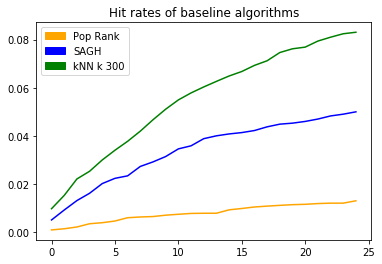

In [0]:
plot_c_baseline_hit_rates(n=25);

# Factorization machines

Now we want to evaluate the actual algorithms of interest - factorization machines. We will use the following variants.

*  (Extended) Pairwise factorization machines
*  (Extended pairwise) Translation-based factorization machines

All variants use BPR (Bayesian Personalized Ranking) loss and the Adagrad optimizer. The implementations are based on https://github.com/rpasricha/TransFM, but heavily adapted. The original implementation is described in:

> Rajiv Pasricha and Julian McAuley.<br>
> **Translation-based factorization machines for sequential recommendation**.<br>
> *In Proceedings of the 12th ACM Conference on Recommender Systems, pages 63-71, ACM, 2018*

**Regarding reproducibility - Scores of own runs might not match exactly**

Seeds are used at all identified places where randomness is used (sampling of negative examples, latent factor initialization), but there still seem to be reproducibility issues because of non-deterministic TensorFlow GPU operations (possibly related to https://github.com/tensorflow/tensorflow/issues/2732) and no use of locking (which could be addressed at possible small runtime costs but was not since we have reproducibility issues anyway).

## Implementation

### Features

Different features can be used.

For details, see the sections **3.5 Representing features**, **3.6 Handling the playlist cold start problem** and **5.1 Evaluation design** of my master's thesis.

The implementations are functions with the same signature which can be set as function parameters.

In [0]:
def _df2col_val(df, col_name, col_vals, with_first_unknown,
                with_unknown_ignored):
  col = df[col_name].to_numpy()

  if with_first_unknown:
    col = np.insert(col, 0, 0)

  if col_name in col_vals:
    val = np.full(len(col), col_vals[col_name])
  else:
    val = np.ones(len(col))
  
  if with_unknown_ignored:
    val[col == 0] = 0.0

  return col, val


def _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals,
            with_first_unknown, with_unknown_ignored):

  col_csrs = []
  for col_name, col_num in zip(col_names, col_nums):
    col, val = _df2col_val(df, col_name, col_vals, with_first_unknown,
                           with_unknown_ignored)
    col_csr = csr_matrix((val, (maincol, col)), shape=(maincol_num, col_num))
    col_csrs.append(col_csr)

  return sp.hstack(col_csrs, format="csr")


def _df2ctx_csr(df, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are ignored
  as the number of context features does not influence ranking.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_interactions, num_ctx_feats]
  """
  maincol_num = len(df)
  maincol = np.arange(maincol_num, dtype=int)
  return _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals, False,
                 True)


def _df2user_csr(df, usercol_name, usercol_num, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the per-user concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are ignored
  as the number of user features does not influence ranking.
  The unknown user (row 0) has no features.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_users, num_user_feats]
  """
  df = df[col_names].drop_duplicates().sort_values(usercol_name)
  usercol, _ = _df2col_val(df, usercol_name, col_vals, True, True)
  return _df2csr(df, usercol, usercol_num, col_names, col_nums, col_vals, True,
                 True)


def _df2item_csr(df, maincol_name, maincol_num, col_names, col_nums, col_vals):
  """
  Create a csr matrix of the per-item concatenated one-hot features
  of the col_names dataframe columns.

  Unknown features (one-hot index 0) are set
  as the number of item features influences ranking.
  The unknown item (row 0) has all unknown feature.

  :param col_vals: feature weighting per column
  :return: csr matrix of dense shape [num_items, num_item_feats]
  """
  df = df[col_names].drop_duplicates().sort_values(maincol_name)
  maincol, _ = _df2col_val(df, maincol_name, col_vals, True, False)
  return _df2csr(df, maincol, maincol_num, col_names, col_nums, col_vals, True,
                 False)


def _meta_df2num(meta_df, col_name):
  return meta_df[col_name].max() + 1


def _item2col(meta_df, col_name):
  item2col = meta_df[["traid", col_name]].drop_duplicates()
  item2col = item2col.sort_values("traid")[col_name].to_numpy()
  item2col = np.insert(item2col, 0, 0)  # unknown column
  return item2col


def _df2encoded_user_csr(seeds_df, meta_df, ucol_name, ucol_num, icol_name,
                         icol_num, col_names, col_nums, col_vals,
                         normalize_fn):

  ui_df = seeds_df[[ucol_name, icol_name]].drop_duplicates()
  ui_df = ui_df.sort_values([ucol_name, icol_name]).reset_index(drop=True)

  ucol, _ = _df2col_val(ui_df, ucol_name, col_vals, True, True)

  # use weighting of user column for individual item columns
  if ucol_name in col_vals:
    icol_vals = {icol_name: col_vals[icol_name]}
  else:
    icol_vals = dict()
  icol, val = _df2col_val(ui_df, icol_name, icol_vals, True, True)

  # normalize weighting of individual item columns
  val = val * normalize_fn(ui_df, meta_df, ucol_name, icol_name)
  
  col_csrs = [csr_matrix((val, (ucol, icol)), shape=(ucol_num, icol_num))]

  if col_names:
    seeds_df = seeds_df[col_names + [ucol_name]].drop_duplicates().sort_values(ucol_name)
    ucol, _ = _df2col_val(seeds_df, ucol_name, col_vals, True, True)

    for col_name, col_num in zip(col_names, col_nums):
      col, val = _df2col_val(seeds_df, col_name, col_vals, True, True)
      col_csr = csr_matrix((val, (ucol, col)), shape=(ucol_num, col_num))
      col_csrs.append(col_csr)

  return sp.hstack(col_csrs, format="csr")

In [0]:
def df2usersitems(df, meta_df, seeds_df=None):
  """
  Function for only using user and item index features.

  Returns a tuple of
   * number of users including unknown user
   * user indices array of shape                [num_interactions]
   * user features csr matrix of dense shape    [num_users, num_user_feats]
   * number of items including unknown item
   * item indices array of shape                [num_interactions]
   * item features csr matrix of dense shape    [num_items, num_item_feats]
   * context features csr matrix of dense shape [num_interactions, num_ctx_feats]
   * array of artists per item indices of shape [num_items]
   * array of albums per item indices of shape  [num_items]
  """

  num_users = _meta_df2num(meta_df, "pid")
  num_items = _meta_df2num(meta_df, "traid")

  item2artist = _item2col(meta_df, "artid")
  item2album = _item2col(meta_df, "albid")

  user_feats = sp.identity(num_users, format="csr")
  item_feats = sp.identity(num_items, format="csr")
  
  user_indices = df["pid"].to_numpy()
  item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
  ctx_feats = None

  return (num_users, user_indices, user_feats, num_items, item_indices,
          item_feats, ctx_feats, item2artist, item2album)


def df2usersitemfeats(col_vals=dict()):
  """
  Function for using user index and item index, album and artist features.
  """
  def _df2usersitemfeats(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2usersitemfeats


def df2all(col_vals=dict()):
  """
  Function for using all features, excluding previous item context features.
   * user features: pid, userid, category
   * item features: traid, albid, artid, year
  """
  def _df2all(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 
    num_years = _meta_df2num(meta_df, "year")
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "category", "pyear"]
    user_col_nums = [num_users, num_true_users, num_categories, num_pyears]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid", "year"]
    item_col_nums = [num_items, num_albums, num_artists, num_years]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2all


def df2allmusic(col_vals=dict()):
  """
  Function for using all features, excluding previous item context features.
   * user features: pid, userid, category
   * item features: traid, albid, artid, year
  """
  def _df2allmusic(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 
    num_years = _meta_df2num(meta_df, "year")
    num_keys = _meta_df2num(meta_df, "key")
    num_loudness = _meta_df2num(meta_df, "loudness")
    num_modes = _meta_df2num(meta_df, "mode")
    num_tempo = _meta_df2num(meta_df, "tempo")
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "category", "pyear",
                 "key", "loudness", "mode", "tempo"]
    user_col_nums = [num_users, num_true_users, num_categories, num_pyears,
                     num_keys, num_loudness, num_modes, num_tempo]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid", "year"]
    item_col_nums = [num_items, num_albums, num_artists, num_years]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2allmusic


def df2usersprevitems(col_vals=dict()):
  """
  Function for only using user, item and previous item index features.
  """
  def _df2usersprevitems(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")
    item_feats = sp.identity(num_items, format="csr")
    
    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = _df2ctx_csr(df, ["prev_traid"], [num_items], col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2usersprevitems


def df2usersprevitemfeats(col_vals=dict()):
  """
  Function for using user index and item index, album and artist features,
  as well as previous item index, album and artist features.
  """
  def _df2usersprevitemfeats(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"), 
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))

    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_feats = sp.identity(num_users, format="csr")

    item_cols = ["traid", "albid", "artid"]
    item_col_nums = [num_items, num_albums, num_artists]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None

    ctx_cols = ["prev_traid", "prev_albid", "prev_artid"]
    ctx_col_nums = [num_items, num_albums, num_artists]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2usersprevitemfeats


def df2prevall(col_vals=dict()):
  """
  Function for using all features.
   * user features: pid, userid, category
   * item features: traid, albid, artid, year
   * context features: prev_traid, prev_albid, prev_artid, prev_year
  """
  def _df2prevall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"), 
                  _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                   _meta_df2num(meta_df, "prev_artid"))
    num_years = max(_meta_df2num(meta_df, "year"),
                 _meta_df2num(meta_df, "prev_year"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "category", "pyear"]
    user_col_nums = [num_users, num_true_users, num_categories, num_pyears]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid", "year"]
    item_col_nums = [num_items, num_albums, num_artists, num_years]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None

    ctx_cols = ["prev_traid", "prev_albid", "prev_artid", "prev_year"]
    ctx_col_nums = [num_items, num_albums, num_artists, num_years]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2prevall


def df2prevallmusic(col_vals=dict()):
  """
  Function for using all features.
   * user features: pid, userid, category, key, loudness, mode, tempo
   * item features: traid, albid, artid, year
   * context features: prev_traid, prev_albid, prev_artid, prev_year,
                       prev_key, prev_loudness, prev_mode, prev_tempo
  """
  def _df2prevallmusic(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"), 
                  _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                   _meta_df2num(meta_df, "prev_artid"))
    num_years = max(_meta_df2num(meta_df, "year"),
                 _meta_df2num(meta_df, "prev_year"))
    num_keys = max(_meta_df2num(meta_df, "key"),
                   _meta_df2num(meta_df, "prev_key"))
    num_loudness = max(_meta_df2num(meta_df, "loudness"),
                       _meta_df2num(meta_df, "prev_loudness"))
    num_modes = max(_meta_df2num(meta_df, "mode"),
                    _meta_df2num(meta_df, "prev_mode"))
    num_tempo = max(_meta_df2num(meta_df, "tempo"),
                    _meta_df2num(meta_df, "prev_tempo"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")

    user_cols = ["pid", "userid", "category", "pyear"]
    user_col_nums = [num_users, num_true_users, num_categories, num_pyears]
    user_feats = _df2user_csr(meta_df, "pid", num_users, user_cols,
                              user_col_nums, col_vals)

    item_cols = ["traid", "albid", "artid", "year",
                 "key", "loudness", "mode", "tempo"]
    item_col_nums = [num_items, num_albums, num_artists, num_years,
                     num_keys, num_loudness, num_modes, num_tempo]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None

    ctx_cols = ["prev_traid", "prev_albid", "prev_artid", "prev_year",
                "prev_key", "prev_loudness", "prev_mode", "prev_tempo"]
    ctx_col_nums = [num_items, num_albums, num_artists, num_years,
                    num_keys, num_loudness, num_modes, num_tempo]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)

    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)
  
  return _df2prevallmusic

In [0]:
def equi_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_equi_weights(g):
    g["weight"] = 1.0 / g.size
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_equi_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights


def sqrt_equi_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_sqrt_equi_weights(g):
    g["weight"] = 1.0 / sqrt(g.size)
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_sqrt_equi_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights


def sqrt_popularity_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_sqrt_popularity_weights(g):
    g["weight"] = (g["weight"] / g["weight"].sum())
    return g

  item_weights = 1.0 / meta_df.groupby(icol_name).size().apply(np.sqrt)
  item_weights = item_weights.rename("weight")
  ui_df = ui_df.join(item_weights, on=icol_name)
  ui_df = ui_df.groupby(ucol_name).apply(_group_sqrt_popularity_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights

def one_weight_normalize(ui_df, meta_df, ucol_name, icol_name):
  def _group_one_weights(g):
    g["weight"] = 1.0
    return g
  
  ui_df = ui_df.groupby(ucol_name).apply(_group_one_weights)
  val_weights = pd.Series([1.0]).append(ui_df["weight"])
  return val_weights

In [0]:
def df2encodedusersitems(col_vals=dict(),
                         encode_fn=sqrt_equi_weight_normalize):
  """
  Function for only using item index features,
  representing users as their items.
  """
  def _df2encodedusersitems(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, [], [], col_vals,
                                        encode_fn)
    else:
      user_feats = None

    item_feats = sp.identity(num_items, format="csr")

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    ctx_feats = None
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersitems


def df2encodedusersall(col_vals=dict(),
                       encode_fn=sqrt_equi_weight_normalize):
  """
  Function for using all features, representing users as their items:
   * user features: playlist items, userid, category
   * item features: traid, albid, artid, year
  """
  def _df2encodedusersall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_items = _meta_df2num(meta_df, "traid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_albums = _meta_df2num(meta_df, "albid") 
    num_artists = _meta_df2num(meta_df, "artid") 
    num_years = _meta_df2num(meta_df, "year")
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_cols = ["userid", "category", "pyear"]
      user_col_nums = [num_true_users, num_categories, num_pyears]
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, user_cols,
                                        user_col_nums, col_vals, encode_fn)
    else:
      user_feats = None
      
    item_cols = ["traid", "albid", "artid", "year"]
    item_col_nums = [num_items, num_albums, num_artists, num_years]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    
    ctx_feats = None
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersall


def df2encodedusersprevall(col_vals=dict(),
                           encode_fn=sqrt_equi_weight_normalize):
  """
  Function for using all features including previous,
  representing users as their items:
   * user features: playlist items, userid, category
   * item features: traid, albid, artid, year
   * context features: prev_traid, prev_albid, prev_artid, prev_year
  """
  def _df2encodedusersprevall(df, meta_df, seeds_df=None):
    num_users = _meta_df2num(meta_df, "pid")
    num_true_users = _meta_df2num(meta_df, "userid")
    num_categories = _meta_df2num(meta_df, "category")
    num_pyears = _meta_df2num(meta_df, "pyear")
    num_items = max(_meta_df2num(meta_df, "traid"),
                    _meta_df2num(meta_df, "prev_traid"))
    num_albums = max(_meta_df2num(meta_df, "albid"), 
                     _meta_df2num(meta_df, "prev_albid"))
    num_artists = max(_meta_df2num(meta_df, "artid"),
                      _meta_df2num(meta_df, "prev_artid"))
    num_years = max(_meta_df2num(meta_df, "year"),
                    _meta_df2num(meta_df, "prev_year"))
    
    item2artist = _item2col(meta_df, "artid")
    item2album = _item2col(meta_df, "albid")
    
    if seeds_df is not None and "traid" in seeds_df.columns:
      user_cols = ["userid", "category", "pyear"]
      user_col_nums = [num_true_users, num_categories, num_pyears]
      user_feats = _df2encoded_user_csr(seeds_df, meta_df, "pid", num_users,
                                        "traid", num_items, user_cols,
                                        user_col_nums, col_vals, encode_fn)
    else:
      user_feats = None
      
    item_cols = ["traid", "albid", "artid", "year"]
    item_col_nums = [num_items, num_albums, num_artists, num_years]
    item_feats = _df2item_csr(meta_df, "traid", num_items, item_cols,
                              item_col_nums, col_vals)

    user_indices = df["pid"].to_numpy()
    item_indices = df["traid"].to_numpy() if "traid" in df.columns else None
    
    ctx_cols = ["prev_traid", "prev_albid", "prev_artid", "prev_year"]
    ctx_col_nums = [num_items, num_albums, num_artists, num_years]
    ctx_feats = _df2ctx_csr(df, ctx_cols, ctx_col_nums, col_vals)
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  return _df2encodedusersprevall

### Sampling

Different methods for sampling negative examples can be used.

We use implementations of the different methods defined in my master's thesis in section **3.7 Customizing negative feedback sampling**.

The implementations are functions with the same signature which can be set as function parameters.

In [0]:
"""
We can't use a njit generator inside a njit generator,
because of nested generator memory leak
https://github.com/numba/numba/issues/3451
https://github.com/numba/numba/issues/1807
"""


@nb.njit()
def _nb_a2bs(as_, num_as, bs):
  a2bs_mapping = [{-1, -2} for _ in range(num_as)]  # -1, -2 as dummy for type inference
  for i in range(as_.size):
    a2bs_mapping[as_[i]].add(bs[i])
  return a2bs_mapping


distribution_nb_spec = [
 ("num_users", nb.int64),
 ("num_items", nb.int64),
 ("user_indices", nb.int64[:]),
 ("item_indices", nb.int64[:]),
 ("items", nb.optional(nb.int64[:])),
 ("rho", nb.optional(nb.float64))
]
class DistributionNb():
  def __init__(self, num_users, num_items, user_indices, item_indices, seed,
               items, rho):
    self.num_users = num_users
    self.num_items = num_items
    self.user_indices = user_indices
    self.item_indices = item_indices
    np.random.seed(seed)
    self.items = items
    self.rho = rho

  def samples(self, size):
    return None


@nb.jitclass(distribution_nb_spec)
class UniformDistributionNb(DistributionNb):
  def samples(self, size):
    return np.random.randint(0, self.num_items, size=size)


@nb.jitclass(distribution_nb_spec)
class InstanceDistributionNb(DistributionNb):
  def samples(self, size):
    return np.random.choice(self.item_indices, size=size)


@nb.jitclass(distribution_nb_spec)
class _ExpDistributionNb(DistributionNb):
  def samples(self, size):
    # inverse transformation sampling from truncated exponential distribution
    rand = np.random.rand(size) * (1.0 - np.exp(-1.0 / self.rho))
    sample_indices = -self.num_items * self.rho * np.log(1.0 - rand)
    sample_indices = sample_indices.astype(np.int64)
    return self.items[sample_indices]


def exp_distribution_nb(rho=1.0):
  def _exp_distribution_nb(num_users, num_items, user_indices, item_indices,
                           seed, items_none, rho_none):
    # item indices sorted by count
    items, counts = np.unique(item_indices, return_counts=True)
    items = np.concatenate((items[np.argsort(-counts)], [0]))  # unknown item
    return _ExpDistributionNb(num_users, num_items, user_indices, item_indices,
                              seed, items, rho)
                              
  return _exp_distribution_nb


accepter_nb_spec = [
 ("num_users", nb.int64),
 ("num_items", nb.int64),
 ("user_indices", nb.int64[:]),
 ("item_indices", nb.int64[:]),
 ("item2artist", nb.int64[:]),
 ("item2album", nb.int64[:])
]
class AccepterNb():
  def __init__(self, num_users, num_items, user_indices, item_indices,
               item2artist, item2album):
    self.num_users = num_users
    self.num_items = num_items
    self.user_indices = user_indices
    self.item_indices = item_indices
    self.item2artist = item2artist
    self.item2album = item2album

  def item2(self):
    return None

  def user2(self):
    if self.item2() is not None:
      return _nb_a2bs(self.user_indices, self.num_users,
                      self.item2()[self.item_indices])
    else:
      return None


@nb.njit(nb.optional(nb.int64[:])())
def _nb_none_intarray():
  return None


@nb.jitclass(accepter_nb_spec)
class AllAccepterNb(AccepterNb):
  def item2(self):
    return _nb_none_intarray()


@nb.jitclass(accepter_nb_spec)
class TrackAccepterNb(AccepterNb):
  def item2(self):
    return np.arange(0, self.num_items)


@nb.jitclass(accepter_nb_spec)
class ArtistAccepterNb(AccepterNb):
  def item2(self):
    return self.item2artist


@nb.jitclass(accepter_nb_spec)
class AlbumAccepterNb(AccepterNb):
  def item2(self):
    return self.item2album


@nb.njit()
def _nb_take_wrap(array, start, end):
  if end <= len(array):
    return array[start:end]
  else:
    modulo_end = end % len(array)
    return np.concatenate((array[start:end], array[:modulo_end]))


@nb.njit()
def _nb_sampler(dist, accepter, epochs, batch_size, num_users, num_items,
                user_indices, item_indices, seed):

  user2accs = accepter.user2()
  item2acc = accepter.item2()

  epoch_size = len(user_indices)
  batches_per_epoch = int(ceil(epoch_size / batch_size))
  epoch_batches_size = batches_per_epoch * batch_size

  interaction_mask = np.arange(0, epoch_size)

  for e in range(epochs):
    np.random.shuffle(interaction_mask)

    neg = dist.samples(epoch_batches_size)
    extra_neg = dist.samples(epoch_batches_size)
    j = 0

    for b in range(batches_per_epoch):
      # batching
      b_start = b * batch_size
      b_end = b_start + batch_size
      b_int_mask = _nb_take_wrap(interaction_mask, b_start, b_end)
      b_neg = neg[b_start:b_end]

      # negative sample acceptance
      if user2accs is not None:
        for i in range(batch_size):
          while item2acc[b_neg[i]] in user2accs[user_indices[b_int_mask[i]]]:
            b_neg[i] = extra_neg[j]
            j += 1
            if j == epoch_batches_size:
              # continue with new samples
              extra_neg = dist.samples(epoch_batches_size)
              j = 0
      
      yield b_int_mask, b_neg


def create_sampler(dist, accepter):
  def _sampler(epochs, batch_size, num_users, num_items,
               user_indices, item_indices, item2artist, item2album, seed=1):
    """
    Create a generator of batches
    of interaction indices and corresponding negative item indices
    using the supplied distribution and accepter.
    """
    _dist = dist(num_users, num_items, user_indices, item_indices, seed, None,
                 None)
    _accepter = accepter(num_users, num_items, user_indices, item_indices,
                         item2artist, item2album)
    return _nb_sampler(_dist, _accepter, epochs, batch_size,
                       num_users, num_items, user_indices, item_indices, seed)

  return _sampler


# Uniform samplers
uniform_sampler = create_sampler(UniformDistributionNb, AllAccepterNb)
accepted_uniform_sampler = create_sampler(UniformDistributionNb, TrackAccepterNb)
accepted_artist_uniform_sampler = create_sampler(UniformDistributionNb, ArtistAccepterNb)
accepted_album_uniform_sampler = create_sampler(UniformDistributionNb, AlbumAccepterNb)

# Instance samplers
instance_sampler = create_sampler(InstanceDistributionNb, AllAccepterNb)
accepted_instance_sampler = create_sampler(InstanceDistributionNb, TrackAccepterNb)
accepted_artist_instance_sampler = create_sampler(InstanceDistributionNb, ArtistAccepterNb)
accepted_album_instance_sampler = create_sampler(InstanceDistributionNb, AlbumAccepterNb)

# Exp samplers
exp_sampler = create_sampler(exp_distribution_nb(), AllAccepterNb)
accepted_exp_sampler = create_sampler(exp_distribution_nb(), TrackAccepterNb)
accepted_artist_exp_sampler = create_sampler(exp_distribution_nb(), ArtistAccepterNb)
accepted_album_exp_sampler = create_sampler(exp_distribution_nb(), AlbumAccepterNb)

In [0]:
@nb.njit()
def _nb_crossbatch_sampler(dist, accepter, epochs, batch_size,
                           num_users, num_items, user_indices, item_indices,
                           seed):

  user2accs = accepter.user2()
  user2accs_np = [np.unique(np.array(list(s)))[2:] for s in user2accs]  # TODO!!
  user2accs_np_max = np.max(np.array([len(l) for l in user2accs_np]))
  item2acc = accepter.item2()

  epoch_size = len(user_indices)
  batches_per_epoch = int(ceil(epoch_size / batch_size))
  epoch_batches_size = batches_per_epoch * batch_size

  interaction_mask = np.arange(0, epoch_size)

  for e in range(epochs):
    np.random.shuffle(interaction_mask)

    neg = dist.samples(epoch_batches_size)
    extra_neg = dist.samples(epoch_batches_size)
    j = 0

    for b in range(batches_per_epoch):
      # batching
      b_start = b * batch_size
      b_end = b_start + batch_size
      b_int_mask = _nb_take_wrap(interaction_mask, b_start, b_end)
      b_neg = neg[b_start:b_end]

      # negative sample acceptance
      if user2accs is not None:
        for i in range(batch_size):
          while item2acc[b_neg[i]] in user2accs[user_indices[b_int_mask[i]]]:
            b_neg[i] = extra_neg[j]
            j += 1
            if j == epoch_batches_size:
              # continue with new samples
              extra_neg = dist.samples(epoch_batches_size)
              j = 0

      # === non-acceptance indexing ===

      # will be filled with non-acceptance indices
      b_u_indices = np.zeros(batch_size * user2accs_np_max, dtype=nb.int64)
      b_i_indices = np.zeros(batch_size * user2accs_np_max, dtype=nb.int64)

      # sorted negative item non-acceptance indices
      i_acc = item2acc[b_neg]
      i_acc_mask = np.argsort(i_acc)
      inverse_i_acc_mask = np.argsort(i_acc_mask)
      i_acc = i_acc[i_acc_mask]

      b_users = user_indices[b_int_mask]
      k = 0
      for bui, b_user in enumerate(b_users):
        # sorted item non-acceptance indices for user b_user at batch index bui
        u_acc = user2accs_np[b_user]
        len_u_acc = len(u_acc)

        # go through sorted negative (i_acc) and user (u_acc)
        # item non-acceptance indices in parallel
        # to find non-accepted batch interactions (bui, bii)
        bii = 0
        j = 0
        while bii < batch_size and j < len_u_acc:
          if i_acc[bii] < u_acc[j]:
            bii += 1
          elif i_acc[bii] > u_acc[j]:
            j += 1
          else:
            b_u_indices[k] = bui
            # fill with original batch index
            b_i_indices[k] = inverse_i_acc_mask[bii]  
            bii += 1
            j += 1
            k += 1

      # ===                         ===

      yield b_int_mask, b_neg, b_u_indices[:k], b_i_indices[:k]


def create_crossbatch_sampler(dist, accepter):
  def _sampler(epochs, batch_size, num_users, num_items,
               user_indices, item_indices, item2artist, item2album, seed=1):
    """
    Return a generator of batches of
     * interaction indices and corresponding negative item indices
     * indices of non-accepted batch cross interactions between those
    
    The non-acceptance indices correspond to a coo matrix of dense shape
    [batch_size, batch_size] and are NOT sorted! They will have to be sorted in
    TensorFlow using tf.sparse.reorder.

    Negative items are chosen from a uniform distribution without replacement,
    so no duplicate negative items occur in a batch.
    
    For accepting items the supplied accepter is used    
    """
    _dist = dist(num_users, num_items, user_indices, item_indices, seed, None,
                 None)
    _accepter = accepter(num_users, num_items, user_indices, item_indices,
                         item2artist, item2album)
    return _nb_crossbatch_sampler(_dist, _accepter, epochs, batch_size,
                                  num_users, num_items,
                                  user_indices, item_indices, seed)

  return _sampler


# Cross-batch samplers
accepted_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, TrackAccepterNb)
accepted_artist_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, ArtistAccepterNb)
accepted_album_crossbatch_sampler = create_crossbatch_sampler(UniformDistributionNb, AlbumAccepterNb)

### TensorFlow

Further, different factorization machine variants can be used.
See sections **3.2 Integrating item features** and **3.3 Integrating sequential features** of my master's thesis for more details.

They variants are implemented in TensorFlow as follows.

In [0]:
class FMArgs():
  """
  Arguments for extended pairwise factorization machine
  """

  def __init__(self,
               epoch_size,
               epochs=1000,
               batch_size=16384,
               num_dims=50,
               init_mean=0.1,
               linear_reg=0.01,
               factors_reg=0.01,
               lr=0.1,
               eval_freq=10):
      """
      :param epoch_size: Epoch size
      :param epochs: Number of epochs to run
      :param batch_size: Mini-batch size
      :param num_dims: Model dimensionality
      :param init_mean: Initialization mean for model weights
      :param linear_reg: Regularization rate for linear weights
      :param factors_reg: Regularization rate for factor weights
      :param lr: Adagrad learning rate
      :param incr_lr: Percentual increase of the learning over epochs
                      (1% = 0.01) 
      :param eval_freq: Frequency at which to evaluate model
      """
      self.epochs = epochs
      self.batch_size = batch_size
      self.batches_per_epoch = int(ceil(epoch_size / batch_size))
      self.num_dims = num_dims
      self.init_mean = init_mean
      self.linear_reg = linear_reg
      self.factors_reg = factors_reg
      self.lr = lr
      self.eval_freq = eval_freq


class TfFM:
  """
  Extended pairwise factorization machine
  """

  def __init__(self, graph, train_dataset, val_dataset, args, top_n):
    
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.args = args
    self.top_n = top_n
    
    self.sess = tf.Session(graph=graph)
    with self.sess.graph.as_default():
      tf.set_random_seed(1)
      (self.handle, self.pred_top_op, self.loss_op, self.train_op,
       self.val_op) =  self._create_model(val_dataset, args, top_n)

  def _create_vars(self, args, val_dataset):
    feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_factors = tf.random_uniform_initializer(-args.init_mean,
                                                        args.init_mean, seed=2)
    
    var_linear = tf.Variable(initializer_linear([feat_dim, 1]), name="linear")
    var_factors = tf.Variable(initializer_factors([feat_dim, args.num_dims]),
                              name="factors")
    
    return var_linear, var_factors

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, feat_shape, feat_shape, na_shape, indices_shape)
  
  def safe_sparse_dense_matmul(self, batch, var):
    """
    Method which can be overwritten to provide a safe version of 
    sparse_dense_matmul for cases where the number of dimensions or
    the sparse matrix are too large (args.num_dims * nnz(batch) > 2^31).
    
    This may occur when recommending the top n items for each user
    which is encoded through its items, because then 
     * the batch / sparse matrix contains a query instance for all items
     * this query instance is large

    See also https://github.com/tensorflow/tensorflow/issues/25971
    """
    return tf.sparse.sparse_dense_matmul(batch, var)

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    var_linear, var_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    ctx_sum = self.safe_sparse_dense_matmul(ctx_batch, var_factors)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)

      # Interaction term
      i_sum = self.safe_sparse_dense_matmul(item_batch, var_factors)
      interaction = tf.multiply(i_sum, ctx_sum)
      interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_pred_top_op(self, pred_batch, idx_batch, n):
    scores, indices = tf.math.top_k(tf.squeeze(pred_batch), k=n)
    item_indices = tf.gather(idx_batch, indices)
    return scores, item_indices

  def _create_utility_op(self, pos_preds, neg_preds, na_batch):
    return pos_preds - neg_preds

  def _create_loss_op(self, gz, args):
    # BPR loss op (add 1e-10 to help with numerical stability)
    return -tf.reduce_sum(tf.log(1e-10 + tf.sigmoid(gz)))

  def _create_l2_reg_grad(self, var, reg):
    return reg * var

  def _create_reg_grad(self, var, grad, args):
    if "linear" in var.name:
      return self._create_l2_reg_grad(var, args.linear_reg)
    else:
      return self._create_l2_reg_grad(var, args.factors_reg)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = tfs.add(to_indicator(ctx_batch), to_indicator(pos_batch))
    nz_batch = tfs.add(nz_batch, to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)

    grads_and_vars = [(tf.multiply(nz_lr, grad), var) for grad, var
                      in grads_and_vars]

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])


  def _create_val_op(self, gz):
    auc_op = tf.cast(tf.squeeze(gz > 0), tf.float32)
    return tf.reduce_mean(auc_op)

  def _create_model(self, val_dataset, args, top_n):
    # Model variables
    vars_ = self._create_vars(args, val_dataset)

    # Batch iterator from data sets, handle decides data set to use
    handle = tf.placeholder(tf.string, shape=[])
    batch_iter = tf.data.Iterator.from_string_handle(
        handle,
        val_dataset.output_types,
        self._create_shape(val_dataset),
        val_dataset.output_classes)
    
    batches_ = batch_iter.get_next()
    idx_batch = batches_[-1]
    na_batch = batches_[-2]
    batches_ = batches_[:-2]
    
    # Prediction op
    pos_preds, neg_preds = self._create_pred_ops(vars_, batches_, args,
                                                 val_dataset)
    
    # Utility op
    gz = self._create_utility_op(pos_preds, neg_preds, na_batch)

    # Top n items prediction op
    preds_top = self._create_pred_top_op(pos_preds, idx_batch, top_n)
    
    # Loss op
    loss_op = self._create_loss_op(gz, args)
    
    # Training op
    train_op = self._create_train_op(loss_op, vars_, batches_, args)
    
    # Validation op
    val_op = self._create_val_op(gz)
    
    return (handle, preds_top, loss_op, train_op, val_op)

  def train(self, save_epochs=[], save_epoch_paths=[]):
    with self.sess.graph.as_default():
      
      # Initialization
      self.sess.run(tf.global_variables_initializer())

      train_iter = self.train_dataset.make_initializable_iterator()
      val_iter = self.val_dataset.make_one_shot_iterator()

      self.sess.run(train_iter.initializer)
      
      train_handle = self.sess.run(train_iter.string_handle())
      val_handle = self.sess.run(val_iter.string_handle())

      # Training scores
      best_auc_epoch = 0
      best_val_auc = -1
      best_rank_epoch = 0
      best_val_rank = self.args.batch_size

      losses = []
      val_losses = []
      val_aucs = []
      val_ranks = []

      # Training loop
      for epoch in range(1, self.args.epochs + 1):
        print("Epoch: {}".format(epoch))

        loss = 0
        for _ in range(self.args.batches_per_epoch):
          loss, _ = self.sess.run([self.loss_op, self.train_op],
                                  feed_dict={self.handle: train_handle})

        losses.append(loss)
        print("\tLast batch loss = {}".format(loss))

        if epoch == 1 or epoch % self.args.eval_freq == 0:
          val_loss, val_scores = self.sess.run([self.loss_op, self.val_op],
                                              feed_dict={self.handle: val_handle})

          if isinstance(val_scores, tuple):
            val_auc, val_rank = val_scores
          else:
            val_auc = val_scores
            val_rank = None

          val_losses.append(val_loss)
          val_aucs.append(val_auc)
          print("\tVal loss = " + str(val_loss))
          print("\tVal AUC = " + str(val_auc))
          
          if val_rank:
            val_ranks.append(val_rank)
            print("\tVal Rank = " + str(val_rank))

          if val_auc > best_val_auc:
            best_auc_epoch = epoch
            best_val_auc = val_auc

          print("\tCurrent max AUC = {} at epoch {}"
                .format(str(best_val_auc), best_auc_epoch))

          if val_rank:
            if val_rank < best_val_rank:
              best_rank_epoch = epoch
              best_val_rank = val_rank

            print("\tCurrent min Rank = {} at epoch {}"
                  .format(str(best_val_rank), best_rank_epoch))

        if epoch in save_epochs:
          save_path = save_epoch_paths[save_epochs.index(epoch)]
          self.save(save_path)
          print("\tSaved to = {}".format(save_path))

      # Closing iterator
      try:
        while True:
          self.sess.run(self.loss_op, feed_dict={self.handle: train_handle})
      except tf.errors.OutOfRangeError:
        pass
          
      return losses, val_losses, val_aucs

  def predict(self, query_dataset):
    with self.sess.graph.as_default():
      
      query_iter = query_dataset.make_one_shot_iterator()
      query_handle = self.sess.run(query_iter.string_handle())
      
      scores_arr = []
      indices_arr = []
      try:
        while True:
          scores, indices = self.sess.run(self.pred_top_op,
                                          feed_dict={self.handle: query_handle})
          scores_arr.append(scores)
          indices_arr.append(indices)
      except tf.errors.OutOfRangeError:
        pass
      
      return np.concatenate(scores_arr), np.concatenate(indices_arr)

  def save(self, save_path):
    with self.sess.graph.as_default():
      saver = tf.train.Saver()
      saver.save(self.sess, save_path)

  def load(self, load_path):
    with self.sess.graph.as_default():
      saver = tf.train.Saver()
      saver.restore(self.sess, load_path)
  
  def close(self):
    self.sess.close()

In [0]:
class TfBatchFM(TfFM):
  """
  Extended pairwise factorization machine with cross-batch sampling
  """

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    var_linear, var_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    ctx_sum = self.safe_sparse_dense_matmul(ctx_batch, var_factors)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Interaction term
      i_sum = self.safe_sparse_dense_matmul(item_batch, var_factors)
      if shared:
        interaction = tf.matmul(ctx_sum, i_sum, transpose_b=True)
      else:
        interaction = tf.multiply(i_sum, ctx_sum)
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

  def _create_utility_op(self, pos_preds, neg_preds, na_batch):
    # eliminate non-accepted negatives
    gz = pos_preds - neg_preds 
    na_gz = tfs.reorder(na_batch)  # sorted indices not guaranteed
    na_gz = tfs.to_dense(na_gz, default_value=False)
    na_gz = tf.cast(na_gz, tf.float32)
    na_gz = tf.multiply(gz, na_gz)
    return gz - na_gz

  def _create_loss_op(self, gz, args):
    # BPR loss op (add 1e-10 to help with numerical stability)
    bprloss_op = tf.log(1e-10 + tf.sigmoid(gz))
    bprloss_op = tf.reduce_mean(bprloss_op, axis=1)
    bprloss_op = tf.reduce_sum(bprloss_op)
    return -bprloss_op

  def _create_val_op(self, gz):
    # AUC op
    auc_gz = tf.expand_dims(tf.linalg.diag_part(gz), 1)
    auc_op = super(TfBatchFM, self)._create_val_op(auc_gz)
    
    # Rank op
    rank_op = tf.cast(gz < 0, tf.float32)
    rank_op = tf.reduce_sum(rank_op, axis=1)
    rank_op = tf.reduce_mean(rank_op)

    return (auc_op, rank_op)

In [0]:
class TfVanillaFM(TfFM):
  """
  Vanilla factorization machine
  """

  def _create_vars(self, args, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]
    cat_feat_dim = feat_dim + item_feat_dim

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_factors = tf.random_uniform_initializer(-args.init_mean,
                                                        args.init_mean, seed=2)
    
    var_linear = tf.Variable(initializer_linear([cat_feat_dim, 1]),
                             name="linear")
    var_factors = tf.Variable(initializer_factors([cat_feat_dim, args.num_dims]),
                              name="factors")
    
    return var_linear, var_factors

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[1][1]
    item_feat_dim = val_dataset.output_shapes[2][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, na_shape, indices_shape)

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):
    
    ctx_batch, pos_batch, neg_batch = batches_
    var_linear, var_factors = vars_

    sq_factors = tf.square(var_factors)

    def _create_pred_op(item_batch):
      batch = tfs.concat(1, [ctx_batch, item_batch])

      # Linear term
      linear = tfs.sparse_dense_matmul(batch, var_linear)

      # Interaction term
      term_1 = tfs.sparse_dense_matmul(batch, var_factors)
      term_1 = tf.reduce_sum(tf.square(term_1), axis=1, keepdims=True)
      term_2 = tfs.sparse_dense_matmul(tf.square(batch), sq_factors)
      term_2 = tf.reduce_sum(term_2, axis=1, keepdims=True)
      interaction = 0.5 * (term_1 - term_2)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)
  
  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = tfs.add(to_indicator(pos_batch), to_indicator(neg_batch))
    nz_batch = to_indicator(tfs.concat(1, [ctx_batch, nz_batch]))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)

    grads_and_vars = [(tf.multiply(nz_lr, grad), var) for grad, var
                      in grads_and_vars]

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TransRecFMArgs(FMArgs):
  """
  Arguments for TransRec factorization machines
  """
  
  def __init__(self, epoch_size, max_norm=1.0, **kwargs):
    """
    :param epoch_size: Epoch size
    :param max_norm: Maximum norm over the model dimensionality,
                     None or zero means no norm clipping
    """
    super(TransRecFMArgs, self).__init__(epoch_size, **kwargs)
    self.max_norm = max_norm


class TfTransRecFM(TfFM):
  """
  TransRec factorization machine
  """

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, item_feat_shape, 
            na_shape, indices_shape)

  def _create_vars(self, args, val_dataset):
    ctx_feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_ctx_factors = tf.random_uniform_initializer(-args.init_mean,
                                                            args.init_mean,
                                                            seed=2)
    initializer_item_factors = tf.random_uniform_initializer(-args.init_mean,
                                                             args.init_mean,
                                                             seed=3)
    
    var_linear = tf.Variable(
        initializer_linear([item_feat_dim, 1]), name="linear")
    
    var_ctx_shape = [ctx_feat_dim, args.num_dims]
    var_ctx_factors = tf.Variable(
        initializer_ctx_factors(var_ctx_shape), name="ctx_factors")
    
    var_item_shape = [item_feat_dim, args.num_dims]
    var_item_factors = tf.Variable(
        initializer_item_factors(var_item_shape), name="item_factors")
    
    return var_linear, var_ctx_factors, var_item_factors

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_

    # Common context terms
    c_factors_sum = self.safe_sparse_dense_matmul(
        ctx_batch, var_ctx_factors) + self.safe_sparse_dense_matmul(
            prev_batch, var_item_factors)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)

      # Item terms
      i_factors_sum = self.safe_sparse_dense_matmul(
          item_batch, var_item_factors)

      # Actual interaction terms
      term_1 = tf.square(c_factors_sum)
      term_2 = tf.multiply(c_factors_sum, i_factors_sum)
      term_3 = tf.square(i_factors_sum)

      interaction = term_1 - 2 * term_2 + term_3
      interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear - interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_reg_grad(self, var, grad, args):
    if "linear" in var.name:
      return self._create_l2_reg_grad(var, args.linear_reg)
    else:
      return self._create_l2_reg_grad(var, args.factors_reg)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    
    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_
    
    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    if args.max_norm:
      clip_opt = tf.contrib.opt.VariableClippingOptimizer(
          opt=opt,
          vars_to_clip_dims={var_item_factors: [1]},
          max_norm=args.max_norm)
    else:
      clip_opt = opt
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = to_indicator(ctx_batch)
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[1]
    grads_and_vars[1] = (tf.multiply(nz_lr, grad), var)

    nz_batch = tfs.add(to_indicator(prev_batch), to_indicator(pos_batch))
    nz_batch = tfs.add(nz_batch, to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[0]
    grads_and_vars[0] = (tf.multiply(nz_lr, grad), var)
    grad, var = grads_and_vars[2]
    grads_and_vars[2] = (tf.multiply(nz_lr, grad), var)

    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)

    with self.sess.graph.control_dependencies([train_op]):
      # frequency adaptive regularization op
      reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                      grad,
                                      self._create_reg_grad(var, grad, args)),
                            var) for grad, var in grads_and_vars]
      with opt.avoid_updating_slots():
        reg_op = clip_opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TfBatchTransRecFM(TfTransRecFM, TfBatchFM):
  """
  TransRec factorization machine with cross-batch sampling
  """

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    ctx_batch, prev_batch, pos_batch, neg_batch = batches_
    var_linear, var_ctx_factors, var_item_factors = vars_

    # Common context terms
    c_factors_sum = self.safe_sparse_dense_matmul(
        ctx_batch, var_ctx_factors) + self.safe_sparse_dense_matmul(
            prev_batch, var_item_factors)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Item terms
      i_factors_sum = self.safe_sparse_dense_matmul(
          item_batch, var_item_factors)

      # Actual interaction terms
      if shared:
        term_1 = tf.reduce_sum(tf.square(c_factors_sum), axis=1, keepdims=True)
        term_2 = tf.matmul(c_factors_sum, i_factors_sum, transpose_b=True)
        term_3 = tf.reduce_sum(tf.square(i_factors_sum), axis=1, keepdims=True)
        term_3 = tf.transpose(term_3)
      else:
        term_1 = tf.square(c_factors_sum)
        term_2 = tf.multiply(c_factors_sum, i_factors_sum)
        term_3 = tf.square(i_factors_sum)

      interaction = term_1 - 2 * term_2 + term_3
      if not shared:
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear - interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

In [0]:
class FFMArgs(FMArgs):
  """
  Arguments for extended pairwise field-aware factorization machines
  """
  
  def __init__(self, epoch_size, num_ctx_fields, num_item_fields, **kwargs):
    """
    :param epoch_size: Epoch size
    :param num_ctx_fields: Number of user/context fields
    :param num_item_fields: Number of item fields
    """
    super(FFMArgs, self).__init__(epoch_size, **kwargs)
    self.num_ctx_fields = num_ctx_fields
    self.num_item_fields = num_item_fields
  

class TfFFM(TfFM):
  """
  Extended pairwise field-aware factorization machine


  To illustrate the vectorized implementation, consider the example with
   * user features pid and userid
   * item features traid, albid and artid

  user / context features have shape [user_features, num_item_fields, num_dims]
  item features have shape [item_features, num_user_fields, num_dims]

  Looking up of relevant user / context and item features results in:

  user features of shape [num_user_fields, num_item_fields, num_dims]
  [userid-traid, userid-albid, userid-artid]
  [pid-traid, pid-albid, pid-artid]

  item features of shape [num_item_fields, num_user_fields, num_dims]
  [traid-userid, traid-pid]
  [albid-userid, albid-pid]
  [artid-userid, artid-pid]

  Now transpose item features and multiply element-wise with user features:

  [userid-traid, pid-traid]     [traid-userid, traid-pid]
  [userid-albid, pid-albid]     [albid-userid, albid-pid]
  [userid-artid, pid-artid]     [artid-userid, artid-pid]

  Sum up
  """

  def _create_shape(self, val_dataset):
    feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    feat_shape = tf.TensorShape([None, feat_dim])
    item_feat_shape = tf.TensorShape([None, item_feat_dim])
    na_shape = tf.TensorShape([None, None])
    indices_shape = tf.TensorShape(None)
    return (feat_shape, item_feat_shape, item_feat_shape, na_shape, indices_shape)

  def _create_vars(self, args, val_dataset):
    ctx_feat_dim = val_dataset.output_shapes[0][1]
    item_feat_dim = val_dataset.output_shapes[1][1]

    initializer_linear = tf.random_uniform_initializer(-args.init_mean,
                                                       args.init_mean, seed=1)
    initializer_ctx_factors = tf.random_uniform_initializer(-args.init_mean,
                                                            args.init_mean,
                                                            seed=2)
    initializer_item_factors = tf.random_uniform_initializer(-args.init_mean,
                                                             args.init_mean,
                                                             seed=3)
    
    var_linear = tf.Variable(
        initializer_linear([item_feat_dim, 1]), name="linear")
    
    var_ctx_shape = [ctx_feat_dim, args.num_item_fields, args.num_dims]
    var_ctx_factors = tf.Variable(
        initializer_ctx_factors(var_ctx_shape), name="ctx_factors")
    
    var_item_shape = [item_feat_dim, args.num_ctx_fields, args.num_dims]
    var_item_factors = tf.Variable(
        initializer_item_factors(var_item_shape), name="item_factors")
    
    return var_linear, var_ctx_factors, var_item_factors

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    var_linear, var_ctx_factors, var_item_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    def _create_lookup_op(batch, factors, num_fields):
      batch_feats = tf.slice(batch.indices, [0, 1], [-1, 1])
      batch_feats = tf.reshape(batch_feats, [-1, num_fields])
      batch_vals = tf.reshape(batch.values, [-1, num_fields])
      batch_vals = tf.expand_dims(tf.expand_dims(batch_vals, axis=2), axis=3)
      emb = tf.nn.embedding_lookup(factors, batch_feats)
      emb = tf.multiply(emb, batch_vals)
      return emb

    ctx_emb = _create_lookup_op(ctx_batch, var_ctx_factors, args.num_ctx_fields)

    def _create_pred_op(item_batch):
      # Linear term
      linear = tf.sparse_tensor_dense_matmul(item_batch, var_linear)

      # Interaction term
      item_emb = _create_lookup_op(item_batch, var_item_factors,
                                   args.num_item_fields)
      interaction = tf.multiply(ctx_emb, tf.transpose(item_emb, [0, 2, 1, 3]))
      interaction = tf.reduce_sum(interaction, axis=[1, 2, 3])
      interaction = tf.expand_dims(interaction, axis=1)

      return linear + interaction
    
    return _create_pred_op(pos_batch), _create_pred_op(neg_batch)

  def _create_train_op(self, loss_op, vars_, batches_, args):
    ctx_batch, pos_batch, neg_batch = batches_

    global_step = tf.Variable(0, trainable=False)

    # training op
    opt = tf.contrib.opt.RegAdagradOptimizer(learning_rate=args.lr)
    grads_and_vars = opt.compute_gradients(loss_op)

    # sparse mini-batch gradients scaling op 
    def to_indicator(s):
      return tf.SparseTensor(s.indices, tf.ones_like(s.values), s.dense_shape)

    nz_batch = to_indicator(ctx_batch)
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    nz_lr = tf.expand_dims(nz_lr, 1)
    grad, var = grads_and_vars[1]
    grads_and_vars[1] = (tf.multiply(nz_lr, grad), var)

    nz_batch = tfs.add(to_indicator(pos_batch), to_indicator(neg_batch))
    nz_batch = tfs.reduce_sum(nz_batch, axis=0)
    nz_lr = 1.0 / tf.expand_dims(tf.maximum(nz_batch, 1.0), 1)
    grad, var = grads_and_vars[0]
    grads_and_vars[0] = (tf.multiply(nz_lr, grad), var)
    nz_lr = tf.expand_dims(nz_lr, 1)
    grad, var = grads_and_vars[2]
    grads_and_vars[2] = (tf.multiply(nz_lr, grad), var)

    # frequency adaptive regularization op
    reg_grads_and_vars = [(tf.where(tf.equal(grad, 0),
                                    grad,
                                    self._create_reg_grad(var, grad, args)),
                           var) for grad, var in grads_and_vars]
    
    # actual training op
    train_op = opt.apply_gradients(grads_and_vars, global_step=global_step)
    with opt.avoid_updating_slots():
      reg_op = opt.apply_gradients(reg_grads_and_vars)

    return tf.group([train_op, reg_op])

In [0]:
class TfBatchFFM(TfFFM, TfBatchFM):

  def _create_pred_ops(self, vars_, batches_, args, val_dataset):

    var_linear, var_ctx_factors, var_item_factors = vars_
    ctx_batch, pos_batch, neg_batch = batches_

    num_fields_multiplied = args.num_ctx_fields * args.num_item_fields

    def _create_lookup_op(batch, factors, num_fields, transpose=False):
      batch_feats = tf.slice(batch.indices, [0, 1], [-1, 1])
      batch_feats = tf.reshape(batch_feats, [-1, num_fields])
      batch_vals = tf.reshape(batch.values, [-1, num_fields])
      batch_vals = tf.expand_dims(tf.expand_dims(batch_vals, axis=2), axis=3)
      emb = tf.nn.embedding_lookup(factors, batch_feats)
      emb = tf.multiply(emb, batch_vals)

      if transpose:
        emb = tf.transpose(emb, [0, 2, 1, 3])
      emb = tf.reshape(emb, [-1, num_fields_multiplied * args.num_dims])

      return emb

    ctx_emb = _create_lookup_op(ctx_batch, var_ctx_factors, args.num_ctx_fields)

    def _create_pred_op(item_batch, shared=False):
      # Linear term
      linear = tfs.sparse_dense_matmul(item_batch, var_linear)
      if shared:
        linear = tf.transpose(linear)

      # Interaction term
      item_emb = _create_lookup_op(item_batch, var_item_factors,
                                   args.num_item_fields, transpose=True)
      if shared:
        interaction = tf.matmul(ctx_emb, item_emb, transpose_b=True)
      else:
        interaction = tf.multiply(item_emb, ctx_emb)
        interaction = tf.reduce_sum(interaction, axis=1, keepdims=True)

      return linear + interaction

    return _create_pred_op(pos_batch), _create_pred_op(neg_batch, shared=True)

### Wrapper

Finally, to use the sampling function, the feature function and the TensorFlow variant implementation combined for evaluation we need to implement wrappers.

First we use wrappers to create batches of train, validation or test instances, using a specific sampling and feature function.

In [0]:
def create_train_batch_generator(epochs, batch_size, df, meta_df, seeds_df,
                                 feature_fn, sampler_fn,
                                 separate_features=False,
                                 item_ctx_features=False):
  """
  Create a training batch generator
  """

  # extract indices and feature mappings from dataframe
  (num_users, user_indices, user_feats, num_items, item_indices, item_feats,
   ctx_feats, item2artist, item2album) = feature_fn(df, meta_df, seeds_df)
  
  # initialize sampler of interactions and negative items
  sampler = sampler_fn(epochs, batch_size, num_users, num_items,
                       user_indices, item_indices, item2artist, item2album)

  # create batches of features from batches of samples
  for l in sampler:
    if len(l) == 4:
      b_pos_mask, b_neg_indices, b_na_indices, b_na_neg_indices = l
      na_ones = np.ones(len(b_na_indices), dtype=bool)
      na_indices = coo_matrix((na_ones, (b_na_indices, b_na_neg_indices)),
                              shape=(batch_size, batch_size))
    else:
      b_pos_mask, b_neg_indices = l
      na_indices = coo_matrix((batch_size, batch_size), dtype=bool)

    b_user_indices = user_indices[b_pos_mask]
    b_pos_indices = item_indices[b_pos_mask]

    user_fs = user_feats[b_user_indices]
    ctx_fs = ctx_feats[b_pos_mask] if ctx_feats is not None else None
    pos_fs = item_feats[b_pos_indices]
    neg_fs = item_feats[b_neg_indices]

    if separate_features and item_ctx_features:
      yield user_fs.tocoo(), ctx_fs.tocoo(), pos_fs.tocoo(), neg_fs.tocoo(), na_indices
    else:
      userctx_fs = sp.hstack([user_fs, ctx_fs])
      if separate_features:
        yield userctx_fs, pos_fs.tocoo(), neg_fs.tocoo(), na_indices
      elif item_ctx_features:
        empty_user_fs = csr_matrix(user_fs.shape)
        pos_fs = sp.hstack([empty_user_fs, pos_fs])
        neg_fs = sp.hstack([empty_user_fs, neg_fs])
        yield userctx_fs, pos_fs, neg_fs, na_indices
      else:
        empty_userctx_fs = csr_matrix(userctx_fs.shape)
        pos_fs = sp.hstack([empty_userctx_fs, pos_fs])
        neg_fs = sp.hstack([empty_userctx_fs, neg_fs])
        userctx_fs._shape = pos_fs.shape
        yield userctx_fs, pos_fs, neg_fs, na_indices


def create_val_batch(batch_size, val_df, meta_df, seeds_df, feature_fn,
                     sampler_fn, separate_features=False,
                     item_ctx_features=False):
  """
  Create a validation batch generator
  """
  repeat = int(ceil(batch_size / len(val_df)))
  epochs = 1
  batch_size = len(val_df) * repeat

  def repeated_feature_fn(df, meta_df, seeds_df):
    (num_users, user_indices, user_feats, num_items, item_indices, item_feats,
     ctx_feats, item2artist, item2album) = feature_fn(df, meta_df, seeds_df)
    
    user_indices = np.repeat(user_indices, repeat)
    item_indices = np.repeat(item_indices, repeat)
    if ctx_feats is not None:
      ctx_feats = ctx_feats.tolil()
      ctx_feats.data = np.repeat(ctx_feats.data, repeat, axis=0)
      ctx_feats.rows = np.repeat(ctx_feats.rows, repeat, axis=0)
      ctx_feats._shape = (ctx_feats.shape[0] * repeat, ctx_feats.shape[1])
      ctx_feats = ctx_feats.tocsr()
    
    return (num_users, user_indices, user_feats, num_items, item_indices,
            item_feats, ctx_feats, item2artist, item2album)

  g = create_train_batch_generator(epochs, batch_size, val_df, meta_df,
                                   seeds_df, repeated_feature_fn, sampler_fn,
                                   separate_features, item_ctx_features)
  
  b = next(g)
  try:
    next(g)
  except StopIteration:
    pass
  
  return b


@nb.njit()
def create_query_items_generator(num_users, user_indices, seed_user_indices,
                                 num_items, seed_item_indices):

  user2items = _nb_a2bs(seed_user_indices, num_users, seed_item_indices)

  for i in range(len(user_indices)):
    user_i = user_indices[i]
    item_indices = np.array([j for j in range(1, num_items)
                             if not bool(j in user2items[user_i])])
    yield i, item_indices
    
  
def create_query_batch_generator(query_df, meta_df, feature_fn,
                                 filter_user_items=False,
                                 separate_features=False,
                                 item_ctx_features=False):
  """
  Create a query batch generator
  """

  # extract user indices and context feature mappings
  # from query context dataframe 
  query_ctx_df = get_query_ctx(query_df)
  (_, user_indices, _, _, _, _, ctx_feats, _,
   _) = feature_fn(query_ctx_df, meta_df)
  
  # extract all indices and other feature mappings
  # from query seeds and meta dataframe
  query_seeds_df = get_query_seeds(query_df)
  (num_users, seed_user_indices, user_feats, num_items, seed_item_indices,
   item_feats, _, _, _) = feature_fn(query_seeds_df, meta_df, query_seeds_df)

  # initialize generator of per-user batches of items
  if filter_user_items:
    g = create_query_items_generator(num_users, user_indices, seed_user_indices,
                                     num_items, seed_item_indices)
  else:
    item_indices = np.arange(num_items)
    g = ((i, item_indices) for i in range(len(user_indices)))

  # create batches of features from per-user batches of items
  for i, item_indices in g: 
    user_fs = user_feats[np.full(len(item_indices), user_indices[i], dtype=int)]
    ctx_fs = ctx_feats[np.full(len(item_indices), i, dtype=int)] if ctx_feats is not None else None
    pos_fs = item_feats[item_indices]

    if separate_features and item_ctx_features:
      yield user_fs.tocoo(), ctx_fs.tocoo(), pos_fs.tocoo(), item_indices
    else:
      userctx_fs = sp.hstack([user_fs, ctx_fs])
      if separate_features:
        yield userctx_fs, pos_fs.tocoo(), item_indices
      elif item_ctx_features:
        empty_user_fs = csr_matrix(user_fs.shape)
        pos_fs = sp.hstack([empty_user_fs, pos_fs])
        yield userctx_fs, pos_fs.tocoo(), item_indices
      else:
        empty_userctx_fs = csr_matrix(userctx_fs.shape)
        pos_fs = sp.hstack([empty_userctx_fs, pos_fs])
        userctx_fs._shape = pos_fs.shape
        yield userctx_fs, pos_fs.tocoo(), item_indices

To use these batches efficiently with the TensorFlow factorization machine implementations, we wrap them as TensorFlow data sets.

In [0]:
def coo2tuple(s, dtype=np.float32):
  s = s.tocoo(copy=False)
  s_indices = np.vstack((s.row.astype(np.int64), s.col.astype(np.int64))).T
  return (s_indices, s.data.astype(dtype), s.shape)


def dummyarray():
  return np.zeros([1], dtype=np.int64)


def dummytuple(dtype=np.float32):
  return (np.zeros([1, 1], dtype=np.int64), np.ones(1, dtype=dtype), [1, 1])


def batch2tuples(b):
  if len(b) == 5:
    # train batch generator with prev batch
    userctx_s, prev_s, pos_s, neg_s, na_s = b
    return (coo2tuple(userctx_s), coo2tuple(prev_s), coo2tuple(pos_s),
            coo2tuple(neg_s), coo2tuple(na_s, dtype=bool), dummyarray())
  elif len(b) == 4:
    if len(b[3].shape) == 2:
      # train batch generator 
      userctx_s, pos_s, neg_s, na_s = b
      return (coo2tuple(userctx_s), coo2tuple(pos_s), coo2tuple(neg_s),
              coo2tuple(na_s, dtype=bool), dummyarray())
    else:
      # query batch generator with prev batch
      userctx_s, prev_s, pos_s, items = b
      return (coo2tuple(userctx_s), coo2tuple(prev_s), coo2tuple(pos_s),
              dummytuple(), dummytuple(dtype=bool), items)
  else:
    # query batch generator
    userctx_s, pos_s, items = b
    return (coo2tuple(userctx_s), coo2tuple(pos_s), dummytuple(),
            dummytuple(dtype=bool), items)


def tuples2tensors(*tuples):
  if len(tuples) == 6:
    userctx, prev, pos, neg, na, items = tuples
    return (tf.SparseTensor(*userctx), tf.SparseTensor(*prev),
            tf.SparseTensor(*pos), tf.SparseTensor(*neg), tf.SparseTensor(*na),
            items)
  else:
    userctx, pos, neg, na, items = tuples
    return (tf.SparseTensor(*userctx), tf.SparseTensor(*pos),
            tf.SparseTensor(*neg), tf.SparseTensor(*na), items)


def batch2dataset(b):
  return tf.data.Dataset.from_tensors(tuples2tensors(*batch2tuples(b)))


def batchgenerator2dataset(g):
  g = (batch2tuples(b) for b in g)
  peek_g = next(g)
  g = itertools.chain([peek_g], g)
  
  f_shape = (tf.int64, tf.float32, tf.int64)
  b_shape = (tf.int64, tf.bool, tf.int64)
  if len(peek_g) == 6:
    g_shape = (f_shape, f_shape, f_shape, f_shape, b_shape, tf.int64)
  else:
    g_shape = (f_shape, f_shape, f_shape, b_shape, tf.int64)
  
  return tf.data.Dataset.from_generator(lambda: g, g_shape).map(tuples2tensors)


def create_train_dataset(epochs, graph, batch_size, df, meta_df, feature_fn,
                         sampler_fn, separate_features=False,
                         item_ctx_features=False):
  """
  Create a training data set consisting of batches of
   * user/context feature sparse tensor
   * positive item feature sparse tensor
   * negative item feature sparse tensor
   * optional non-accepted negative items for users sparse tensor
   * dummy item indices array
  """
  with graph.as_default():
    seeds_df = df
    g = create_train_batch_generator(epochs, batch_size, df, meta_df, seeds_df,
                                     feature_fn, sampler_fn, separate_features,
                                     item_ctx_features)
    return batchgenerator2dataset(g)


def create_val_dataset(graph, batch_size, val_df, val_query_df, meta_df,
                       feature_fn, sampler_fn, separate_features=False,
                       item_ctx_features=False):
  """
  Create a validation data set consisting of
  a single batch of the same structure as the training data set batches.

  The single batch has positive items repeated with different negative items
  to have size similar to batch_size (of the training data set batches).
  """
  with graph.as_default():
    seeds_df = get_query_seeds(val_query_df)
    b = create_val_batch(batch_size, val_df, meta_df, seeds_df, feature_fn,
                         sampler_fn, separate_features, item_ctx_features)
    
    return batch2dataset(b).repeat()
  

def create_query_dataset(graph, query_df, meta_df, feature_fn,
                         filter_user_items=False, separate_features=False,
                         item_ctx_features=False):
  """
  Create a query data set consisting of per-user batches of
   * user/context feature sparse tensor
   * query item feature sparse tensor
   * dummy negative sparse tensor
   * dummy non-accepted sparse tensor
   * query item indices array
  """
  with graph.as_default():
    g = create_query_batch_generator(query_df, meta_df, feature_fn,
                                     filter_user_items, separate_features,
                                     item_ctx_features)
    return batchgenerator2dataset(g).prefetch(1)

Finally we use a wrapper which, given a specific sampling function, feature function and factorization machine variant implementation, can be fitted on and transform dataframes in our required format. It also supports saving and loading models.

In [0]:
class FM:
  """
  Wrapper around different TensorFlow factorization machines to use with
   * train, validation, validation query, test and test query dataframes
   * different arguments, feature and sampler / not accepted functions
  """

  def __init__(self, fm_type, train_df, val_query_df, val_df, feature_fn,
               sampler_fn, val_sampler_fn, args, n=500,
               separate_features=False, item_ctx_features=False):

    # train data set used for metadata
    meta_df = train_df

    with tf.device('/gpu:0'):
      tf.reset_default_graph()
      graph = tf.Graph()

      train_dataset = create_train_dataset(args.epochs, graph, args.batch_size,
                                           train_df, meta_df, feature_fn,
                                           sampler_fn, separate_features,
                                           item_ctx_features)

      # important pipelining for better performance
      with graph.as_default():
        train_dataset = train_dataset.prefetch(args.batches_per_epoch)
      
      val_dataset = create_val_dataset(graph, args.batch_size, val_df,
                                       val_query_df, meta_df, feature_fn,
                                       val_sampler_fn, separate_features,
                                       item_ctx_features)
      
      self.fm = fm_type(graph, train_dataset, val_dataset, args, n)
      self.meta_df = meta_df
      self.feature_fn = feature_fn
      self.n = n
      self.separate_features = separate_features
      self.item_ctx_features = item_ctx_features
  
  @with_time
  def fit(self, save_epochs=[], save_epoch_paths=[]):
    return self.fm.train(save_epochs, save_epoch_paths)
  
  @with_time
  def transform(self, query_df, filter_user_tracks=False):
    query_dataset = create_query_dataset(self.fm.sess.graph, query_df,
                                         self.meta_df, self.feature_fn,
                                         filter_user_tracks,
                                         self.separate_features,
                                         self.item_ctx_features)
    
    scores, indices = self.fm.predict(query_dataset)
    return pd.DataFrame({
        "score": scores,
        "pid": get_query_ctx(query_df)["pid"].repeat(self.n),
        "traid": indices
    })

  def save(self, save_path):
    self.fm.save(save_path)
  
  def load(self, load_path):
    self.fm.load(load_path)
  
  def close(self):
    self.fm.close()

Using this wrapper, we can create a general evaluation function as well as a general function plotting the fitting process.

These general functions and dictionaries are the only wrappers we will need to care about.

In [0]:
fm_fits = dict()
fm_evals = dict()


def fit_fm_args(fm_type, args, args_name, train_df, val_query_df, val_df,
                load=False, feature_fn=df2usersitems,
                sampler_fn=uniform_sampler, val_sampler_fn=uniform_sampler,
                separate_features=False, item_ctx_features=False):
  """
  Fits, saves and returns a FM. Fills fm_fits.

  Can also load a fitted FM instead of fitting and saving it again.
  """
  fm = FM(fm_type, train_df, val_query_df, val_df, feature_fn, sampler_fn,
          val_sampler_fn, args, separate_features=separate_features,
          item_ctx_features=item_ctx_features)

  fit_name = "{}{}.pickle".format(models_dirname, args_name)
  model_name = "{}{}.ckpt".format(models_dirname, args_name)

  if load:
    with open(fit_name, "rb") as f:
     fm_fits[args_name] = pickle.load(f)
    fm.load(model_name)
  else:
    (losses, val_losses, val_scores), fit_time = fm.fit()

    if isinstance(val_scores, tuple):
      val_aucs, val_ranks = val_scores
    else:
      val_aucs = val_scores
      val_ranks = None

    fm_fits[args_name] = {
        "fit_time": fit_time,
        "losses": losses,
        "val_losses": val_losses,
        "val_aucs": val_aucs,
        "val_ranks": val_ranks
    }
    with open(fit_name, "wb") as f:
      pickle.dump(fm_fits[args_name], f)
    fm.save(model_name)
      
  return fm


def fit_fm_args_epochs(fm_type, args, args_names, args_epochs, train_df,
                       val_query_df, val_df, load=False,
                       feature_fn=df2usersitems, sampler_fn=uniform_sampler,
                       val_sampler_fn=uniform_sampler, separate_features=False,
                       item_ctx_features=False):
  """
  Fits, saves and returns FMs at the given epochs.
  Fills fm_fits for the FM with most epochs.

  Can also load fitted FMs instead of fitting and saving it again.

  This is obviously more efficient than
   * fitting a FM for 100 epochs and saving it
   * fitting a FM for 200 epochs and saving it
   * ...
  """
  fm = FM(fm_type, train_df, val_query_df, val_df, feature_fn, sampler_fn,
          val_sampler_fn, args, separate_features=separate_features,
          item_ctx_features=item_ctx_features)
  
  args_name = args_names[-1]
  fit_name = "{}{}.pickle".format(models_dirname, args_name)
  model_names = ["{}{}.ckpt".format(models_dirname, name) for name
                 in args_names]

  if load:
    with open(fit_name, "rb") as f:
      fm_fits[args_name] = pickle.load(f)
  else:
    (losses, val_losses, val_scores), fit_time = fm.fit(save_epochs=args_epochs,
                                                        save_epoch_paths=model_names)

    if isinstance(val_scores, tuple):
      val_aucs, val_ranks = val_scores
    else:
      val_aucs = val_scores
      val_ranks = None

    fm_fits[args_name] = {
        "fit_time": fit_time,
        "losses": losses,
        "val_losses": val_losses,
        "val_aucs": val_aucs,
        "val_ranks": val_ranks
    }
    with open(fit_name, "wb") as f:
      pickle.dump(fm_fits[args_name], f)

  for model_name in model_names:
    fm.load(model_name)
    yield fm


def eval_fm(fm, args_name, test_query_df, test_df, silent=False,
            filter_user_tracks=False, with_hit_rates=False):
  """
  Evaluates a FM and returns the recommendation dataframe. Fills fm_evals.
  """
  fm_evals[args_name] = dict()

  fm_df, fm_evals[args_name]["trans_time"] = fm.transform(test_query_df,
                                                          filter_user_tracks)
  
  if with_hit_rates:
    fm_evals[args_name]["hit_rates"] = hit_rates(fm_df, test_df)
    fm_evals[args_name]["hit_rate"] = fm_evals[args_name]["hit_rates"][0]
  else:
    fm_evals[args_name]["hit_rate"] = hit_rate(fm_df, test_df) 
  fm_evals[args_name]["ndcg"] = ndcg(fm_df, test_df)
  
  if not silent:
    print("{:.6f} hit rate\n{:.6f} ndcg".format(
        fm_evals[args_name]["hit_rate"], fm_evals[args_name]["ndcg"]))
    if args_name in fm_fits:
      print("\n{:.5f}s fit time".format(fm_fits[args_name]["fit_time"]))
    print("{:.5f}s trans time".format(fm_evals[args_name]["trans_time"]))
  
  return fm_df

In [0]:
def plot_fm_fit(args_name, bottom_val_auc=0.75, top_val_auc=1.0, rows=1, row=0):
  """
  Plots losses, validation losses and validation AUCs of a FM's fitting.
  Uses fm_fits.
  """
  plt.figure(figsize=(12, rows * 4))
  
  losses = fm_fits[args_name]["losses"]
  losses_ax = plt.subplot(rows, 3, row * 3 + 1)
  plt.plot(losses)
  if row == 0:
    plt.title("Losses")
  
  val_losses = fm_fits[args_name]["val_losses"]
  val_epochs = [i * args.eval_freq for i in range(len(val_losses))]
  plt.subplot(rows, 3, row * 3 + 2, sharey=losses_ax)
  plt.plot(val_epochs, val_losses)
  if row == 0:
    plt.title("Val losses")
  
  aucs = fm_fits[args_name]["val_aucs"]
  plt.subplot(rows, 3, row * 3 + 3)
  plt.plot(val_epochs, aucs, color="red")
  plt.ylim(bottom=bottom_val_auc, top=top_val_auc)
  if row == 0:
    plt.title("Val AUCs")
  
  plt.subplots_adjust(wspace=0.4)


def plot_fm_fits(args_names, bottom_val_auc=0.75, top_val_auc=1.0):
  rows = len(args_names)
  for row, args_name in enumerate(args_names):
    plot_fm_fit(args_name, bottom_val_auc, top_val_auc, rows, row)

## Evaluation

For the last-track split evaluation, we use a train-validation-test split and evaluate the different parameters and variants on the validation set.

We will then only evaluate the best parameters on the test set.

In [68]:
train_df, val_df, val_query_df = last_track_split(df, as_val=True,
                                                  n_test_users=1000)

names_df = to_names_index(train_df)
drop_names([train_df, val_df, val_query_df])

val_df.head()

,pid,category,timestamp,userid,sid,traid,pyear,artid,albid,year,key,loudness,mode,tempo,b_tempo,bak_tempo,prev_traid,prev_albid,prev_artid,prev_year,prev_loudness,prev_tempo,prev_mode,prev_key
0,111,2,1998-02-01 00:00:00,87,4,1317,1,213,1144,0,1,1,1,11,6,113,893,787,296,18,14,11,2,5
1,153,2,1998-02-05 00:00:00,114,4,6404,1,540,2573,11,12,8,1,8,12,172,218,204,168,11,8,15,1,4
2,162,13,1998-02-08 00:00:00,123,1,49226,1,2537,22916,4,12,4,1,7,7,125,1258,1095,676,34,5,5,1,8
3,206,9,1999-01-08 13:20:00,142,4,2068,2,219,269,10,6,17,1,16,0,53,1611,1360,563,0,11,6,1,9
4,292,2,1998-04-09 00:00:00,23,2,5082,1,31,3636,30,2,2,1,13,13,185,2179,359,231,28,19,2,1,11


In [0]:
with_names(get_query_seeds(val_query_df).head(6)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
26309,111,Mellon Collie And The Infinite Sadness,Mellon Collie And The Infinite Sadness,The Smashing Pumpkins
122946,111,Take The Money And Run,Box Set,Steve Miller Band
582360,111,When I Come Around (Album Version),Dookie,Green Day
214956,111,Rio,Decade,Duran Duran
674370,111,Big Empty (LP Version),Thank You,Stone Temple Pilots
297976,111,Billie Jean,King Of Pop,Michael Jackson


In [0]:
with_names(val_df.head(1)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
0,111,Heartache Tonight (LP Version),Selected Works 1972-1999,Eagles


In [0]:
with_names(get_query_seeds(val_query_df[val_query_df["pid"] == 153]).head(9)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
68949,153,Trigger Hippie,Parts Of The Process,Morcheeba
528363,153,Over,Portishead,Portishead
163984,153,Dirt,Dead Elvis/Int'l version,Death In Vegas
252918,153,Speed,1995,Atari Teenage Riot
712332,153,Put A Lid On It,Contact,Squirrel Nut Zippers
329737,153,Step On,Pills 'n' Thrills And Bellyaches,Happy Mondays
789151,153,The Number Song,Endtroducing,DJ Shadow
387555,153,Hell is Around the Corner,Le Transporteur 3 - The Transporter III (Origi...,Tricky
846969,153,Why Do I Lie?,Fever In Fever Out,Luscious Jackson


In [0]:
with_names(val_df[val_df["pid"] == 153].head(1)[["pid", "traid"]], names_df)

,pid,traname,albname,artname
1,153,The Candy Man (Album Version),Viva! La Woman,Cibo Matto


We can load already fitted FMs or fit them ourselves.

In [0]:
load=False

### Pairwise factorization machines

#### Hyperparameters

At first, we try to find reasonable hyperparameter values for pairwise factorization machines.

In particular we consider:

*   *linear_reg*: The regularization rate for the linear weights
*   *factors_reg*: The regularization rate for the latent factor weights
*   *num_dims / k*: The number of dimensions
*   *lr*: The Adagrad learning rate





**Mini-batch size**

As mini-batch size we use *16384* which is quite large but has been shown to work fine in previous experiments.

A large mini-batch size is important for a faster runtime of our TensorFlow implementation.

**Regularizaton rate**

In [0]:
regs = [0.01, 0.03, 0.1, 0.3]
reg_names = ["fm_lreg{}".format(reg) for reg in regs]

for reg, reg_name in zip(regs, reg_names):
  args = FMArgs(len(train_df), linear_reg=reg)
  fm = fit_fm_args(TfFM, args, reg_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, reg_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lreg0.01.ckpt
0.003000 hit rate
0.055913 ndcg

326.07315s fit time
23.98030s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lreg0.03.ckpt
0.004000 hit rate
0.055360 ndcg

326.02468s fit time
25.70334s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lreg0.1.ckpt
0.004000 hit rate
0.056572 ndcg

326.17878s fit time
23.41429s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lreg0.3.ckpt
0.003000 hit rate
0.055247 ndcg

326.55864s fit time
23.09151s trans time


In [0]:
regs = [0.03, 0.1]
reg_names = ["fm_freg{}".format(reg) for reg in regs]

for reg, reg_name in zip(regs, reg_names):
  args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=reg)
  fm = fit_fm_args(TfFM, args, reg_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, reg_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_freg0.03.ckpt
0.005000 hit rate
0.061557 ndcg

326.57961s fit time
19.25758s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_freg0.1.ckpt
0.001000 hit rate
0.046212 ndcg

324.68812s fit time
12.55182s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03)
fm = fit_fm_args(TfFM, args, "fm_freg0.03", train_df, val_query_df, val_df,
                 load=True)
fm_df = eval_fm(fm, "fm_freg0.03", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_freg0.03.ckpt
0.005000 hit rate
0.061557 ndcg

326.57961s fit time
17.38056s trans time


,score,pid,traname,albname,artname
0,5.379768,111,Creep (Explicit),Pablo Honey,Radiohead
0,5.375965,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,5.215573,111,Just Like Heaven,Kiss Me Kiss Me Kiss Me,The Cure
0,5.194291,111,Blister In The Sun,Violent Femmes,Violent Femmes
0,5.177338,111,Where Is My Mind?,Wave Of Mutilation: Best Of Pixies,Pixies


In [0]:
with_names(fm_df[fm_df["pid"] == 153].head(), names_df)

,score,pid,traname,albname,artname
1,4.753779,153,Sour Times,Dummy,Portishead
1,4.690751,153,6 Underground,6 Underground Rewired,Sneaker Pimps
1,4.521921,153,Big Time Sensuality,Post Live,Björk
1,4.465311,153,Sexy Boy (Cassius Remix),Sexy Boy,Air
1,4.389088,153,Midnight In A Perfect World,Endtroducing.....,DJ Shadow


**Number of dimensions**

In [0]:
ks = [100, 150, 200, 250, 300, 350, 400]
k_names = ["fm_k{}".format(k) for k in ks]

for k, k_name in zip(ks, k_names):
  args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03, num_dims=k)
  fm = fit_fm_args(TfFM, args, k_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, k_name, val_query_df, val_df, filter_user_tracks=True,
          silent=True)

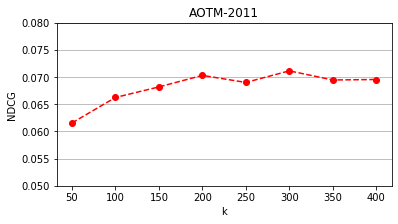

In [0]:
plt.figure(figsize=(6, 3))

k_ndcgs = [fm_evals[k_name]["ndcg"] for k_name in ["fm_freg0.03"] + k_names]
plt.plot([50] + ks, k_ndcgs, "o--", color="red")
plt.xticks([50] + ks)
plt.ylim(bottom=0.05, top=0.08)
plt.grid(True, axis="y")

plt.ylabel("NDCG")
plt.xlabel("k")
plt.title("AOTM-2011");

In [0]:
k_hit_rates = [fm_evals[k_name]["hit_rate"] for k_name
               in ["fm_freg0.03"] + k_names]
pd.DataFrame.from_records([k_ndcgs, k_hit_rates], columns=[50] + ks,
                          index=["NDCG", "Hit rate"])

,50,100,150,200,250,300,350,400
NDCG,0.061557,0.066248,0.068189,0.070311,0.069013,0.071146,0.069467,0.069552
Hit rate,0.005000,0.007000,0.007000,0.010000,0.008000,0.010000,0.009000,0.011000


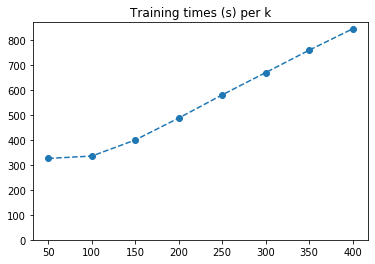

In [0]:
k_times = [fm_fits[k_name]["fit_time"] for k_name in ["fm_freg0.03"] + k_names]
plt.plot([50] + ks, k_times, "o--")
plt.xticks([50] + ks)
plt.ylim(bottom=0.0)

plt.title("Training times (s) per k");

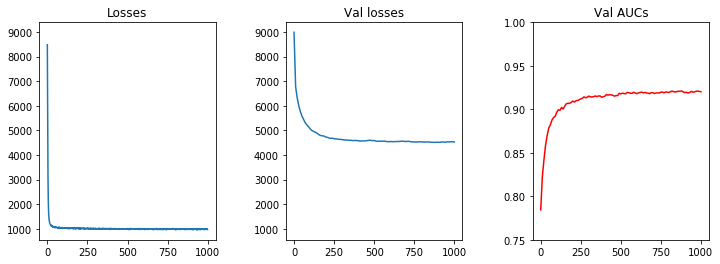

In [0]:
plot_fm_fit("fm_k150")

**Learning rate**

We try increasing the learning rate to see if this leads to improvements. It does not.

In [0]:
lrs = [0.3, 0.6]
lr_names = ["fm_lr{}".format(lr) for lr in lrs]

for lr, lr_name in zip(lrs, lr_names):
  args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03,
                num_dims=150, lr=lr)
  fm = fit_fm_args(TfFM, args, lr_name, train_df, val_query_df, val_df,
                   load=load)
  eval_fm(fm, lr_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lr0.3.ckpt
0.011000 hit rate
0.071564 ndcg

441.05170s fit time
23.68284s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_lr0.6.ckpt
0.007000 hit rate
0.068613 ndcg

446.38037s fit time
23.47231s trans time


#### Sampling

Next, we evaluate the different sampling methods.

We begin with cross-batch BPR loss.

As this requires a lower batch size of *4096*, it will also be compared against normal BPR with a batch size of *4096*. For the lower batch size the regularization rates also have to be adjusted. The linear regularization rate is lowered from *0.3* to *0.01* and the factors regularization rate is lowered from *0.01* to *0.001*.

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=0.1)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_uniform_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_e100.ckpt
0.004000 hit rate
0.058254 ndcg
17.68883s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_e250.ckpt
0.012000 hit rate
0.069419 ndcg
17.21986s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_e500.ckpt
0.015000 hit rate
0.071993 ndcg
17.31549s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_e1000.ckpt
0.013000 hit rate
0.076067 ndcg

1940.53610s fit time
17.56521s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_lr1.0_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_uniform_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_lr1.0_e100.ckpt
0.000000 hit rate
0.011659 ndcg
24.38778s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_lr1.0_e250.ckpt
0.000000 hit rate
0.012780 ndcg
25.30577s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_lr1.0_e500.ckpt
0.001000 hit rate
0.014072 ndcg
24.55501s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_lr1.0_e1000.ckpt
0.002000 hit rate
0.014850 ndcg

1923.44399s fit time
25.07554s trans time


In [0]:
args = FMArgs(len(train_df), num_dims=150, batch_size=4096,
              linear_reg=0.03, factors_reg=0.01)

args_epochs = [100, 250, 500, 1000]
args_names = ["fm_b4096_aes_e{}".format(args_epoch) for args_epoch
              in args_epochs]

fms = fit_fm_args_epochs(TfFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_exp_sampler,
                         val_sampler_fn=accepted_uniform_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_aes_e100.ckpt
0.007000 hit rate
0.062052 ndcg
23.27485s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_aes_e250.ckpt
0.008000 hit rate
0.068795 ndcg
22.99018s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_aes_e500.ckpt
0.012000 hit rate
0.073804 ndcg
24.88223s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_b4096_aes_e1000.ckpt
0.012000 hit rate
0.077331 ndcg

2001.61546s fit time
23.83913s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=0.1)

args_epochs = [100, 250, 500, 1000]
args_names = ["bfm_e{}_lr0.1".format(args_epoch) for args_epoch in args_epochs]

fms = fit_fm_args_epochs(TfBatchFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_crossbatch_sampler,
                         val_sampler_fn=accepted_crossbatch_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e100_lr0.1.ckpt
0.008000 hit rate
0.063280 ndcg
16.02481s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e250_lr0.1.ckpt
0.011000 hit rate
0.071409 ndcg
20.05725s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e500_lr0.1.ckpt
0.012000 hit rate
0.074002 ndcg
21.38830s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e1000_lr0.1.ckpt
0.012000 hit rate
0.076861 ndcg

5802.32877s fit time
20.94397s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

args_epochs = [100, 250, 500, 1000]
args_names = ["bfm_e{}_lr1.0".format(args_epoch) for args_epoch in args_epochs]

fms = fit_fm_args_epochs(TfBatchFM, args, args_names, args_epochs, train_df,
                         val_query_df, val_df, load=load,
                         sampler_fn=accepted_crossbatch_sampler,
                         val_sampler_fn=accepted_crossbatch_sampler)

for fm, args_name in zip(fms, args_names):
  eval_fm(fm, args_name, val_query_df, val_df, filter_user_tracks=True)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e100_lr1.0.ckpt
0.014000 hit rate
0.073487 ndcg
19.08586s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e250_lr1.0.ckpt
0.013000 hit rate
0.076667 ndcg
19.23572s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e500_lr1.0.ckpt
0.015000 hit rate
0.079642 ndcg
19.94491s trans time
INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_e1000_lr1.0.ckpt
0.010000 hit rate
0.078000 ndcg

5824.21546s fit time
19.02542s trans time


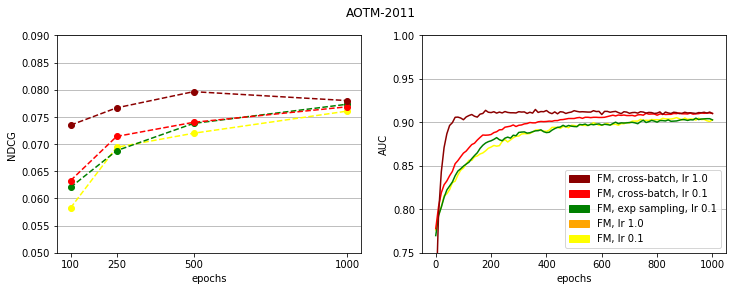

In [0]:
fm_names = ["fm_b4096_e{}".format(args_epoch) for args_epoch in args_epochs]
fm_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm_names]

fm1_names = ["fm_b4096_lr1.0_e{}".format(args_epoch) for args_epoch in args_epochs]
fm1_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm1_names]

fm_aes_names = ["fm_b4096_aes_e{}".format(args_epoch) for args_epoch in args_epochs]
fm_aes_ndcgs = [fm_evals[fm_name]["ndcg"] for fm_name in fm_aes_names]

bfm_names = ["bfm_e{}_lr0.1".format(args_epoch) for args_epoch in args_epochs]
bfm_ndcgs = [fm_evals[bfm_name]["ndcg"] for bfm_name in bfm_names]

bfm1_names = ["bfm_e{}_lr1.0".format(args_epoch) for args_epoch in args_epochs]
bfm1_ndcgs = [fm_evals[bfm_name]["ndcg"] for bfm_name in bfm1_names]


plt.figure(figsize=(6*2, 4))
plt.suptitle("AOTM-2011")

plt.subplot(1, 2, 1)

plt.plot(args_epochs, fm_ndcgs, "o--", color="yellow")
plt.plot(args_epochs, fm1_ndcgs, "o--", color="orange")
plt.plot(args_epochs, fm_aes_ndcgs, "o--", color="green")
plt.plot(args_epochs, bfm_ndcgs, "o--", color="red")
plt.plot(args_epochs, bfm1_ndcgs, "o--", color="darkred")
plt.xticks(args_epochs)
plt.ylim(bottom=0.05, top=0.09)

plt.grid(True, axis="y")
plt.ylabel("NDCG")
plt.xlabel("epochs")

fm_aucs = fm_fits["fm_b4096_e1000"]["val_aucs"]
fm1_aucs = fm_fits["fm_b4096_lr1.0_e1000"]["val_aucs"]

fm_aes_aucs = fm_fits["fm_b4096_aes_e1000"]["val_aucs"]

bfm_aucs = fm_fits["bfm_e1000_lr0.1"]["val_aucs"]
bfm1_aucs = fm_fits["bfm_e1000_lr1.0"]["val_aucs"]

val_epochs = [i * args.eval_freq for i in range(len(fm_aucs))]

plt.subplot(1, 2, 2)

plt.grid(True, axis="y")
plt.plot(val_epochs, fm_aucs, color="yellow")
plt.plot(val_epochs, fm1_aucs, color="orange")
plt.plot(val_epochs, fm_aes_aucs, color="green")
plt.plot(val_epochs, bfm_aucs, color="red")
plt.plot(val_epochs, bfm1_aucs, color="darkred")
plt.ylim(bottom=0.75, top=1.0)

green_patch = mpatches.Patch(color="green", label="FM, exp sampling, lr 0.1")
yellow_patch = mpatches.Patch(color="yellow", label="FM, lr 0.1")
orange_patch = mpatches.Patch(color="orange", label="FM, lr 1.0")
red_patch = mpatches.Patch(color="red", label="FM, cross-batch, lr 0.1")
dred_patch = mpatches.Patch(color="darkred", label="FM, cross-batch, lr 1.0")
patches = [dred_patch, red_patch, green_patch, orange_patch, yellow_patch]
plt.legend(handles=patches)

plt.ylabel("AUC")
plt.xlabel("epochs");

In [0]:
args_labels = ["FM, lr 0.1", "FM, lr 1.0",
               "FM, cross-batch, lr 0.1", "FM, cross-batch, lr 1.0"]
args_names = ["fm_b4096_e1000", "fm_b4096_lr1.0_e1000",
              "bfm_e1000_lr0.1", "bfm_e1000_lr1.0"]
fit_times = [fm_fits[args_name]["fit_time"] for args_name in args_names]

pd.DataFrame.from_records([fit_times], columns=args_labels, index=["Fit times"])

,"FM, lr 0.1","FM, lr 1.0","FM, cross-batch, lr 0.1","FM, cross-batch, lr 1.0"
Fit times,1482.603974,1472.59813,4866.022604,4819.809624


One can see that cross-batch BPR with a high learning rate leads to a faster training convergence. It requires only about a tenth of the epochs for the same NDCG but requires only four times as much time per epoch in our specific TensorFlow implementation.

Next are the different normal sampling methods.

In [0]:
sampler_names = ["us", "aus", "alus", "aaus",
                 "es", "aes", "ales", "aaes",
                 "is", "ais", "alis", "aais"]
sampler_names = ["fm_{}".format(name) for name in sampler_names]
sampler_fns = [uniform_sampler, accepted_uniform_sampler, accepted_album_uniform_sampler, accepted_artist_uniform_sampler,
               exp_sampler, accepted_exp_sampler, accepted_album_exp_sampler, accepted_artist_exp_sampler,
               instance_sampler, accepted_instance_sampler, accepted_album_instance_sampler, accepted_artist_instance_sampler]

args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03, num_dims=150)

for sampler_name, sampler_fn in zip(sampler_names, sampler_fns):
  fm = fit_fm_args(TfFM, args, sampler_name, train_df, val_query_df, val_df,
                   load=load, sampler_fn=sampler_fn,
                   val_sampler_fn=accepted_uniform_sampler)
  eval_fm(fm, sampler_name, val_query_df, val_df, filter_user_tracks=True,
          silent=True)

In [0]:
cols = ["all", "track", "album", "artist"]
index = ["uniform", "exp", "instance"]
rows = np.array([fm_evals[sampler_name]["ndcg"] for sampler_name
                 in sampler_names])
rows = rows.reshape((-1, len(cols)))
pd.DataFrame.from_records(rows, columns=cols, index=index)

,all,track,album,artist
uniform,0.067631,0.068877,0.068904,0.068288
exp,0.070010,0.070308,0.073002,0.071870
instance,0.060083,0.061385,0.062533,0.061446


One can see that exp sampling improves the NDCG but instance sampling does not - it probably overrepresents frequent tracks too much.

For accepted track, album and artist sampling no clear trends can be observed.

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_us", train_df, val_query_df,
                 val_df, load=load)

eval_fm(fm, "bfm_us", val_query_df, val_df, filter_user_tracks=True);

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_aas", train_df, val_query_df,
                 val_df, load=load,
                 sampler_fn=accepted_artist_crossbatch_sampler,
                 val_sampler_fn=accepted_crossbatch_sampler)

eval_fm(fm, "bfm_aas", val_query_df, val_df, filter_user_tracks=True,
        silent=True);

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_als", train_df, val_query_df,
                 val_df, load=load,
                 sampler_fn=accepted_album_crossbatch_sampler,
                 val_sampler_fn=accepted_crossbatch_sampler)

eval_fm(fm, "bfm_als", val_query_df, val_df, filter_user_tracks=True);

In [0]:
cols = ["all", "track", "album", "artist"]
index = ["cross-batch"]
rows = np.array([fm_evals[sampler_name]["ndcg"] for sampler_name
                 in ["bfm_us", "bfm_e100_lr1.0", "bfm_als", "bfm_aas"]])
rows = rows.reshape((-1, len(cols)))
pd.DataFrame.from_records(rows, columns=cols, index=index)

,all,track,album,artist
cross-batch,0.073129,0.073487,0.071985,0.073346


For cross-batch loss again no clear trends can be observed accepted track, album and artist sampling.

#### Features

We will now evaluate different features.

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_useritemfeats", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersitemfeats({}))

fm_df = eval_fm(fm, "bfm_useritemfeats", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_useritemfeats.ckpt
0.011000 hit rate
0.080193 ndcg

512.59293s fit time
16.55084s trans time


,score,pid,traname,albname,artname
0,5.221032,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,4.982966,111,Bohemian Rhapsody,Bohemian Rhapsody,Queen
0,4.859371,111,Today,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins
0,4.820422,111,The Joker,Box Set,Steve Miller Band
0,4.782730,111,Landslide,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_all", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2all({
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "bfm_all", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_all.ckpt
0.013000 hit rate
0.087661 ndcg

525.43375s fit time
34.62815s trans time


Next we try adding previous track features and try to find a good weighting for them.

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersprevitems({"prev_traid": 1.0}))

fm_df = eval_fm(fm, "bfm_prev", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prev.ckpt
0.009000 hit rate
0.067948 ndcg

531.38934s fit time
18.61659s trans time


,score,pid,traname,albname,artname
0,5.379888,111,Bohemian Rhapsody,Bohemian Rhapsody,Queen
0,5.345016,111,Blister In The Sun,Violent Femmes,Violent Femmes
0,5.183496,111,Hungry Like The Wolf,Singles Box '81 - '85,Duran Duran
0,5.143578,111,Should I Stay Or Should I Go,From Here To Eternity,The Clash
0,5.104984,111,1979,Rarities & B-Sides,The Smashing Pumpkins


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev_05", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersprevitems({"prev_traid": 0.5}))

eval_fm(fm, "bfm_prev_05", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prev_05.ckpt
0.016000 hit rate
0.074890 ndcg

531.23530s fit time
18.67472s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev_025", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersprevitems({"prev_traid": 0.25}))

eval_fm(fm, "bfm_prev_025", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prev_025.ckpt
0.015000 hit rate
0.074409 ndcg

532.90898s fit time
18.60770s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_previtemfeats", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2usersprevitemfeats({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25}))

fm_df = eval_fm(fm, "bfm_previtemfeats", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_previtemfeats.ckpt
0.012000 hit rate
0.080623 ndcg

590.80877s fit time
29.33308s trans time


,score,pid,traname,albname,artname
0,5.441099,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,5.277347,111,Every Little Thing She Does Is Magic,The Very Best Of Sting And The Police,The Police
0,5.233240,111,Today,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins
0,5.146961,111,Just What I Needed,Just What I Needed / I'm In Touch With Your Wo...,The Cars
0,5.146037,111,Under Pressure (With Commentary),Absolute Greatest (Includes track by track com...,Queen & David Bowie


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

fm_df = eval_fm(fm, "bfm_prevall", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prevall.ckpt
0.012000 hit rate
0.090646 ndcg

620.83396s fit time
43.60361s trans time


,score,pid,traname,albname,artname
0,5.905605,111,Today,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins
0,5.814911,111,Under Pressure (With Commentary),Absolute Greatest (Includes track by track com...,Queen & David Bowie
0,5.811210,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,5.726590,111,You're All I've Got Tonight,Rarities & B-Sides,The Smashing Pumpkins
0,5.707715,111,Interstate Love Song (LP Version),Thank You,Stone Temple Pilots


In [76]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall_music", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevallmusic({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "prev_key": 0.25 * 0.125,
                     "prev_mode": 0.25 * 0.125,
                     "prev_loudness": 0.25 * 0.25,
                     "prev_tempo": 0.25 * 0.25,
                     "year": 0.125,
                     "pyear": 0.125,
                     "key": 0.125,
                     "mode": 0.125,
                     "loudness": 0.25,
                     "tempo": 0.25}))

fm_df = eval_fm(fm, "bfm_prevall_music", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prevall_music.ckpt
0.012000 hit rate
0.085977 ndcg

790.22589s fit time
65.16483s trans time


,score,pid,traname,albname,artname
0,6.369234,111,Today,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins
0,6.263896,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,6.130464,111,Interstate Love Song (LP Version),Thank You,Stone Temple Pilots
0,5.688198,111,Loser,Mellow Gold,Beck
0,5.667681,111,Say It Ain't So,Weezer,Weezer


In [83]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall_music2", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevallmusic({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "prev_key": 0.0,
                     "prev_mode": 0.0,
                     "prev_loudness": 0.25 * 0.25,
                     "prev_tempo": 0.25 * 0.25,
                     "year": 0.125,
                     "pyear": 0.125,
                     "key": 0.0,
                     "mode": 0.0,
                     "loudness": 0.25,
                     "tempo": 0.25}))

fm_df = eval_fm(fm, "bfm_prevall_music2", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prevall_music2.ckpt
0.012000 hit rate
0.088700 ndcg

791.53279s fit time
64.86868s trans time


,score,pid,traname,albname,artname
0,6.163813,111,Under Pressure (With Commentary),Absolute Greatest (Includes track by track com...,Queen & David Bowie
0,5.869071,111,Bohemian Rhapsody,Bohemian Rhapsody,Queen
0,5.699685,111,Hotel California,Hotel California / Pretty Maids All In A Row [...,Eagles
0,5.605333,111,Today,Rotten Apples_ The Smashing Pumpkins Greatest ...,The Smashing Pumpkins
0,5.604313,111,Mary Jane's Last Dance,Greatest Hits,Tom Petty And The Heartbreakers


In [84]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall_music3", train_df, val_query_df,
                 val_df, load=load,
                 feature_fn=df2prevallmusic({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "prev_key": 0.0,
                     "prev_mode": 0.0,
                     "prev_loudness": 0.25 * 0.25,
                     "prev_tempo": 0.25 * 0.0,
                     "year": 0.125,
                     "pyear": 0.125,
                     "key": 0.0,
                     "mode": 0.0,
                     "loudness": 0.25,
                     "tempo": 0.0}))

fm_df = eval_fm(fm, "bfm_prevall_music3", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prevall_music3.ckpt
0.013000 hit rate
0.089560 ndcg

782.08086s fit time
64.57469s trans time


,score,pid,traname,albname,artname
0,6.361062,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,6.176349,111,You're All I've Got Tonight,Rarities & B-Sides,The Smashing Pumpkins
0,6.072747,111,Bohemian Rhapsody,Bohemian Rhapsody,Queen
0,5.903652,111,Bullet With Butterfly Wings,Rarities & B-Sides,The Smashing Pumpkins
0,5.836464,111,Interstate Love Song (LP Version),Thank You,Stone Temple Pilots


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01,
              num_dims=150, batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prev_trans", train_df, val_query_df,
                 val_df, load=load, item_ctx_features=True,
                 feature_fn=df2usersprevitems({"prev_traid": 0.25}))

eval_fm(fm, "bfm_prev_trans", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prev_trans.ckpt
0.009000 hit rate
0.072271 ndcg

484.16445s fit time
17.63371s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_previtemfeats_trans", train_df, 
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2usersprevitemfeats({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25}))

eval_fm(fm, "bfm_previtemfeats_trans", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_previtemfeats_trans.ckpt
0.010000 hit rate
0.078258 ndcg

521.54210s fit time
29.02329s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_prevall_trans", train_df, val_query_df,
                 val_df, load=load, item_ctx_features=True,
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.125 * 0.25,
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "bfm_prevall_trans", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_prevall_trans.ckpt
0.008000 hit rate
0.086228 ndcg

549.35614s fit time
41.87552s trans time


Finally, we also evaluate the effects of the cold-start playlist representation methods.

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_encodedusersprevall", train_df,
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

fm_df = eval_fm(fm, "bfm_encodedusersprevall", val_query_df, val_df,
                filter_user_tracks=True);

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_encodedusersprevall.ckpt
0.011000 hit rate
0.085250 ndcg

710.67725s fit time
60.07926s trans time


,score,pid,traname,albname,artname
0,6.288714,111,Bohemian Rhapsody,Bohemian Rhapsody,Queen
0,6.198445,111,Roxanne,Roxanne,The Police
0,5.786688,111,Mary Jane's Last Dance,Greatest Hits,Tom Petty And The Heartbreakers
0,5.702484,111,Comfortably Numb,Is There Anybody Out There? / The Wall Live P...,Pink Floyd
0,5.695571,111,1979,Rarities & B-Sides,The Smashing Pumpkins


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_encodedusersprevall_equi", train_df,
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125},
                     equi_weight_normalize))

eval_fm(fm, "bfm_encodedusersprevall_equi", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_encodedusersprevall_equi.ckpt
0.009000 hit rate
0.076243 ndcg

718.84134s fit time
59.91629s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchFM, args, "bfm_encodedusersprevall_ones", train_df,
                 val_query_df, val_df, load=load, item_ctx_features=True,
                 feature_fn=df2encodedusersprevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125},
                     one_weight_normalize))

eval_fm(fm, "bfm_encodedusersprevall_ones", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bfm_encodedusersprevall_ones.ckpt
0.010000 hit rate
0.084094 ndcg

713.71503s fit time
60.29995s trans time


### Vanilla factorization machines

In [0]:
args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03, num_dims=150,
              batch_size=4096*4, epochs=100)

fm = fit_fm_args(TfFM, args, "fm_prevall", train_df, val_query_df,
                 val_df, load=load, 
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

fm_df = eval_fm(fm, "fm_prevall", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/fm_prevall.ckpt
0.007000 hit rate
0.073361 ndcg

407.46221s fit time
42.72005s trans time


,score,pid,traname,albname,artname
0,4.788515,111,Smells Like Teen Spirit,With The Lights Out - Box Set,Nirvana
0,4.715292,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,4.654889,111,Wish You Were Here,The Electronic Tribute to Pink Floyd,Pink Floyd Tribute
0,4.618999,111,Loser,Mellow Gold,Beck
0,4.588201,111,Lithium,Sliver - The Best Of The Box,Nirvana


In [0]:
args = FMArgs(len(train_df), linear_reg=0.1, factors_reg=0.03, num_dims=150,
              batch_size=4096*4, epochs=100)

fm = fit_fm_args(TfVanillaFM, args, "vfm_prevall", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

fm_df = eval_fm(fm, "vfm_prevall", val_query_df, val_df,
                filter_user_tracks=True)

with_names(fm_df.head(), names_df)

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/vfm_prevall.ckpt
0.004000 hit rate
0.069432 ndcg

1064.50742s fit time
345.55483s trans time


,score,pid,traname,albname,artname
0,7.891500,111,Under Pressure (With Commentary),Absolute Greatest (Includes track by track com...,Queen & David Bowie
0,7.637059,111,Just Like Heaven,Kiss Me Kiss Me Kiss Me,The Cure
0,7.583895,111,Loser,Mellow Gold,Beck
0,7.580750,111,1979,Rarities & B-Sides,The Smashing Pumpkins
0,7.447689,111,I Laid And I Wondered,Living Country Blues USA Vol. 5 - Mississippi ...,"James ""Son"" Thomas & Cleveland ""Broomman"" Jones"


### TransRec factorization machines

In [0]:
train_prev_df = train_df[train_df["prev_traid"] != 0]

In [0]:
args = TransRecFMArgs(len(train_prev_df), linear_reg=0.03, factors_reg=0.01,
                      num_dims=150, batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchTransRecFM, args, "btransfm", train_prev_df,
                 val_query_df, val_df, load=load, separate_features=True,
                 item_ctx_features=True,
                 feature_fn=df2usersprevitems())

eval_fm(fm, "btransfm", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/btransfm.ckpt
0.011000 hit rate
0.068952 ndcg

473.75609s fit time
14.86638s trans time


In [0]:
args = TransRecFMArgs(len(train_prev_df), linear_reg=0.03, factors_reg=0.01,
                      num_dims=150, batch_size=4096, lr=1.0, epochs=100)

fm = fit_fm_args(TfBatchTransRecFM, args, "btransfm_prevall", train_prev_df,
                 val_query_df, val_df, load=load, separate_features=True,
                 item_ctx_features=True,
                 feature_fn=df2prevall({
                     "prev_year": 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "btransfm_prevall", val_query_df, val_df,
        filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/btransfm_prevall.ckpt
0.012000 hit rate
0.077857 ndcg

550.61220s fit time
32.61000s trans time


### Field-aware factorization machines

In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=1, num_item_fields=3,
               linear_reg=0.03, factors_reg=0.01, num_dims=50, epochs=100,
               batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFFM, args, "bffm_itemfeats", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2usersitemfeats({}))

eval_fm(fm, "bffm_itemfeats", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bffm_itemfeats.ckpt
0.011000 hit rate
0.070030 ndcg

437.68082s fit time
16.56231s trans time


In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=4, num_item_fields=4,
               linear_reg=0.03, factors_reg=0.01, num_dims=50, epochs=100,
               batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFFM, args, "bffm_all", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2all({
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "bffm_all", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bffm_all.ckpt
0.010000 hit rate
0.070414 ndcg

652.22168s fit time
27.32177s trans time


In [0]:
args = FFMArgs(len(train_df), num_ctx_fields=4+4, num_item_fields=4,
               linear_reg=0.03, factors_reg=0.01, num_dims=50, epochs=100,
               batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFFM, args, "bffm_prevall", train_df, val_query_df,
                 val_df, load=load, separate_features=True,
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "bffm_prevall", val_query_df, val_df, filter_user_tracks=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/bffm_prevall.ckpt
0.001000 hit rate
0.019889 ndcg

1026.37523s fit time
40.18216s trans time


### Distributed factorization machines

In [0]:
train_df = train_df.drop(columns=["timestamp", "sid"])
val_df = val_df.drop(columns=["timestamp", "sid"])
val_query_df = val_query_df.drop(columns=["timestamp", "sid"])

In [0]:
val_queryseeds_df = get_query_seeds(val_query_df)
val_queryctx_df = get_query_ctx(val_query_df)

In [0]:
max_user_cols = ["category", "pid", "userid", "pyear"]
max_item_cols = ["traid", "artid", "albid", "year"]
max_prev_item_cols = ["prev_traid", "prev_artid", "prev_albid", "prev_year"]

max_df = train_df[max_user_cols + max_item_cols].max()
for prev_col, col in zip(max_prev_item_cols, max_item_cols):
  max_df[prev_col] = max_df[col]

train_df = (train_df - 1) % max_df
val_df = (val_df - 1) % max_df
val_queryseeds_df = (val_queryseeds_df - 1) % max_df
val_queryctx_df = (val_queryctx_df - 1) % max_df

In [0]:
train_df.to_csv("AOTM-2011-train.csv")
val_df.to_csv("AOTM-2011-val.csv")
val_queryseeds_df.to_csv("AOTM-2011-val-queryseeds.csv")
val_queryctx_df.to_csv("AOTM-2011-val-queryctx.csv")

### Final

Finally, we perform an evaluation on the test set and a comparison with the baselines.

In [0]:
train_df, test_df, test_query_df = last_track_split(df, as_val=False,
                                                    n_test_users=1000)

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFM, args, "f_bfm", train_df, test_query_df,
                 test_df, load=load)

eval_fm(fm, "f_bfm", test_query_df, test_df, filter_user_tracks=True,
        with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/f_bfm.ckpt
0.013000 hit rate
0.087465 ndcg

4599.91801s fit time
15.50193s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFM, args, "f_bfm_prevall", train_df, test_query_df,
                 test_df, load=load,
                 feature_fn=df2prevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "f_bfm_prevall", test_query_df, test_df, filter_user_tracks=True,
        with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/f_bfm_prevall.ckpt
0.017000 hit rate
0.099636 ndcg

6150.21671s fit time
46.38467s trans time


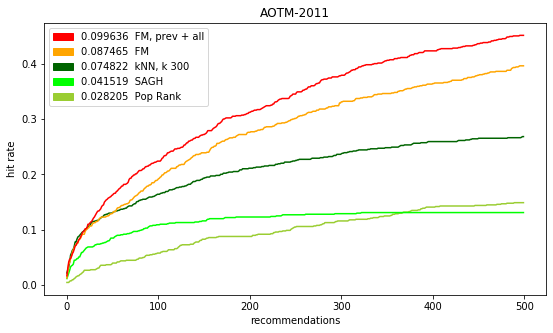

In [0]:
def plot_final_hit_rates(n=500):
  plt.figure(figsize=(9, 5))
  plt.plot(pop_rank_hit_rates[:n], color="yellowgreen")
  plt.plot(sagh_hit_rates[:n], color="lime")
  plt.plot(knn300_hit_rates[:n], color="darkgreen")
  plt.plot(fm_evals["f_bfm"]["hit_rates"], color="orange")
  plt.plot(fm_evals["f_bfm_prevall"]["hit_rates"], color="red")

  yellowgreen_patch = mpatches.Patch(color="yellowgreen", label="{:.6f}  Pop Rank".format(
      pop_rank_ndcg))
  green_patch = mpatches.Patch(color="lime", label="{:.6f}  SAGH".format(
      sagh_ndcg))
  dgreen_patch = mpatches.Patch(color="darkgreen", label="{:.6f}  kNN, k 300".format(
      knn300_ndcg))
  orange_patch = mpatches.Patch(color="orange", label="{:.6f}  FM".format(
      fm_evals["f_bfm"]["ndcg"]))
  red_patch = mpatches.Patch(color="red", label="{:.6f}  FM, prev + all".format(
      fm_evals["f_bfm_prevall"]["ndcg"])) 
  patches = [red_patch, orange_patch,
             dgreen_patch, green_patch, yellowgreen_patch]
  plt.legend(handles=patches)

  plt.ylabel("hit rate")
  plt.xlabel("recommendations")
  plt.title("AOTM-2011")
  
plot_final_hit_rates();

## Cold start evaluation

#### Final

Finally, we also perform an cold-start split evaluation on the test set and a comparison with the baselines.

The parameters are the same as for the last-track split evaluation and not tuned for the cold-start split.

In [0]:
train_df, test_df, test_query_df = users_split(df, 1000, n_seed_tracks=5)
names_df = to_names_index(train_df)
drop_names([train_df, test_df, test_query_df])

In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFM, args, "cf_bfm", train_df,
                 test_query_df, test_df, load=load,
                 feature_fn=df2encodedusersitems())

eval_fm(fm, "cf_bfm", test_query_df, test_df,
        filter_user_tracks=True, with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/cf_bfm.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.008491 hit rate
0.108833 ndcg

4722.62057s fit time
24.47545s trans time


In [0]:
args = FMArgs(len(train_df), linear_reg=0.03, factors_reg=0.01, num_dims=150,
              batch_size=4096, lr=1.0)

fm = fit_fm_args(TfBatchFM, args, "cf_bfm_prevall", train_df,
                 test_query_df, test_df, load=load,
                 feature_fn=df2encodedusersprevall({
                     "prev_traid": 0.25,
                     "prev_albid": 0.25,
                     "prev_artid": 0.25,
                     "prev_year": 0.25 * 0.125,
                     "year": 0.125,
                     "pyear": 0.125}))

eval_fm(fm, "cf_bfm_prevall", test_query_df, test_df,
        filter_user_tracks=True, with_hit_rates=True);

INFO:tensorflow:Restoring parameters from /drive/My Drive/models/aotm-2011/cf_bfm_prevall.ckpt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.006633 hit rate
0.119926 ndcg

7361.57926s fit time
53.07277s trans time


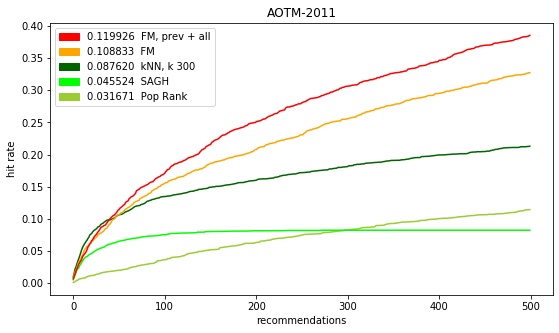

In [0]:
def plot_cfinal_hit_rates(n=500):
  plt.figure(figsize=(9, 5))
  plt.plot(c_pop_rank_hit_rates[:n], color="yellowgreen")
  plt.plot(c_sagh_hit_rates[:n], color="lime")
  plt.plot(c_knn300_hit_rates[:n], color="darkgreen")
  plt.plot(fm_evals["cf_bfm"]["hit_rates"][:n], color="orange")
  plt.plot(fm_evals["cf_bfm_prevall"]["hit_rates"][:n], color="red")

  yellowgreen_patch = mpatches.Patch(color="yellowgreen", label="{:.6f}  Pop Rank".format(
      c_pop_rank_ndcg))
  green_patch = mpatches.Patch(color="lime", label="{:.6f}  SAGH".format(
      c_sagh_ndcg))
  dgreen_patch = mpatches.Patch(color="darkgreen", label="{:.6f}  kNN, k 300".format(
      c_knn300_ndcg))
  orange_patch = mpatches.Patch(color="orange", label="{:.6f}  FM".format(
      fm_evals["cf_bfm"]["ndcg"]))
  red_patch = mpatches.Patch(color="red", label="{:.6f}  FM, prev + all".format(
      fm_evals["cf_bfm_prevall"]["ndcg"])) 
  patches = [red_patch, orange_patch, 
             dgreen_patch, green_patch, yellowgreen_patch]
  plt.legend(handles=patches)

  plt.ylabel("hit rate")
  plt.xlabel("recommendations")
  plt.title("AOTM-2011")
  
plot_cfinal_hit_rates();

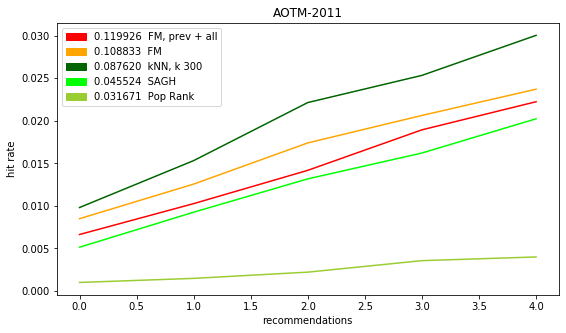

In [0]:
plot_cfinal_hit_rates(n=5);